In [2]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers  import Dense, LSTM, Flatten, Dropout, Conv1D
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError

from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
from random import randrange
from pandas import Series
from matplotlib import pyplot

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller


from sklearn.preprocessing import MinMaxScaler

tf.executing_eagerly()


True

In [8]:
errors = ['MSE', 'RMSE', 'MAE']
evals = {}

# Data Analysis

Reading the data

In [10]:
df = pd.read_csv('energy_dataset_cleaned.csv', parse_dates=['time'], index_col='time')

First of all lets see how many days worth of data do we have

In [11]:
df.index[-1] - df.index[0] 

Timedelta('1460 days 23:00:00')

We can see that we have 1461 days worth of data which is euqal to 4 years

Lets plot visualize every generation type

<AxesSubplot:title={'center':'generation solar'}, xlabel='time'>

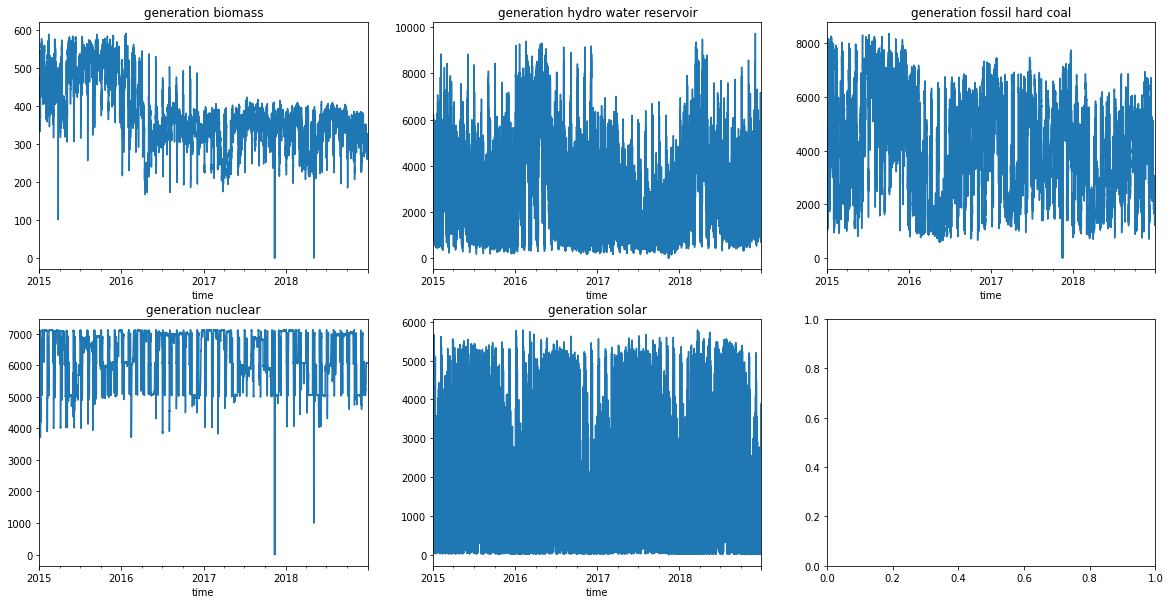

In [13]:
figure, axes = plt.subplots(2, 3, figsize=(20, 10))


df['generation biomass'].plot(ax=axes[0][0], title='generation biomass')
df['generation hydro water reservoir'].plot(ax=axes[0][1], title='generation hydro water reservoir')
df['generation fossil hard coal'].plot(ax=axes[0][2], title='generation fossil hard coal')
df['generation nuclear'].plot(ax=axes[1][0], title='generation nuclear')
df['generation solar'].plot(ax=axes[1][1], title='generation solar')

<AxesSubplot:xlabel='time'>

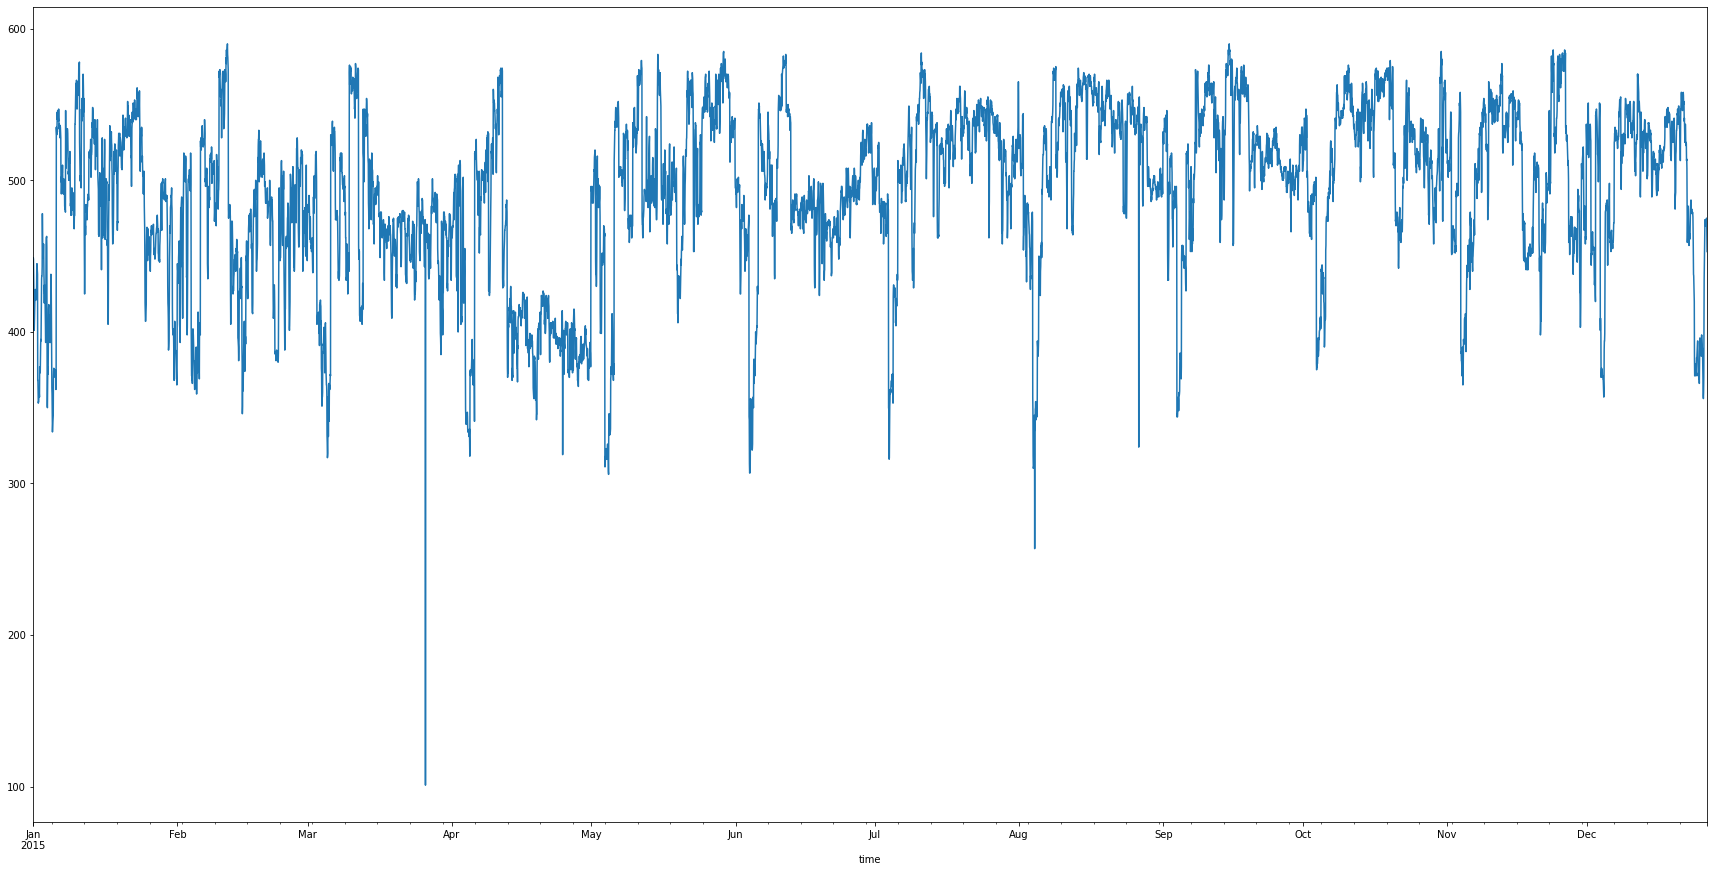

In [14]:
df['generation biomass'][:24*30*12].plot(figsize=(30, 15))

In [1]:
result = seasonal_decompose(df['generation fossil hard coal'][:24*30*6], model='additive')
result.plot()
pyplot.show()

NameError: name 'seasonal_decompose' is not defined

In [42]:
result = adfuller(df['generation nuclear'][:24*30*12])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.680778
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


<AxesSubplot:xlabel='time'>

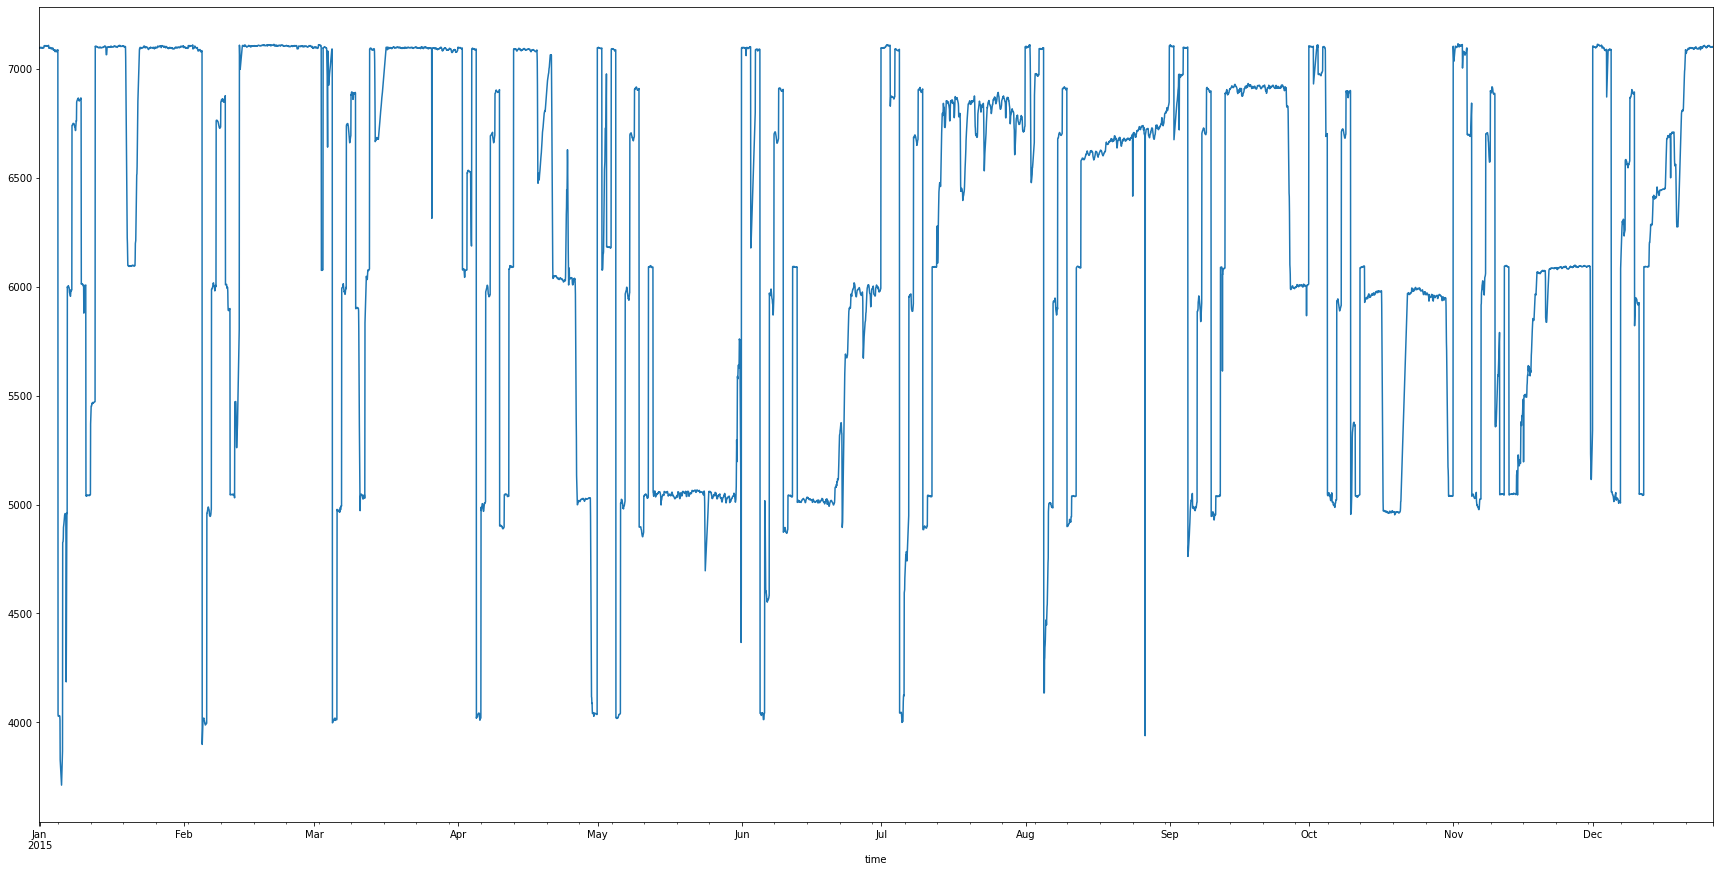

In [6]:
df['generation nuclear'][:24*30*12].plot(figsize=(30, 15))

<AxesSubplot:xlabel='time'>

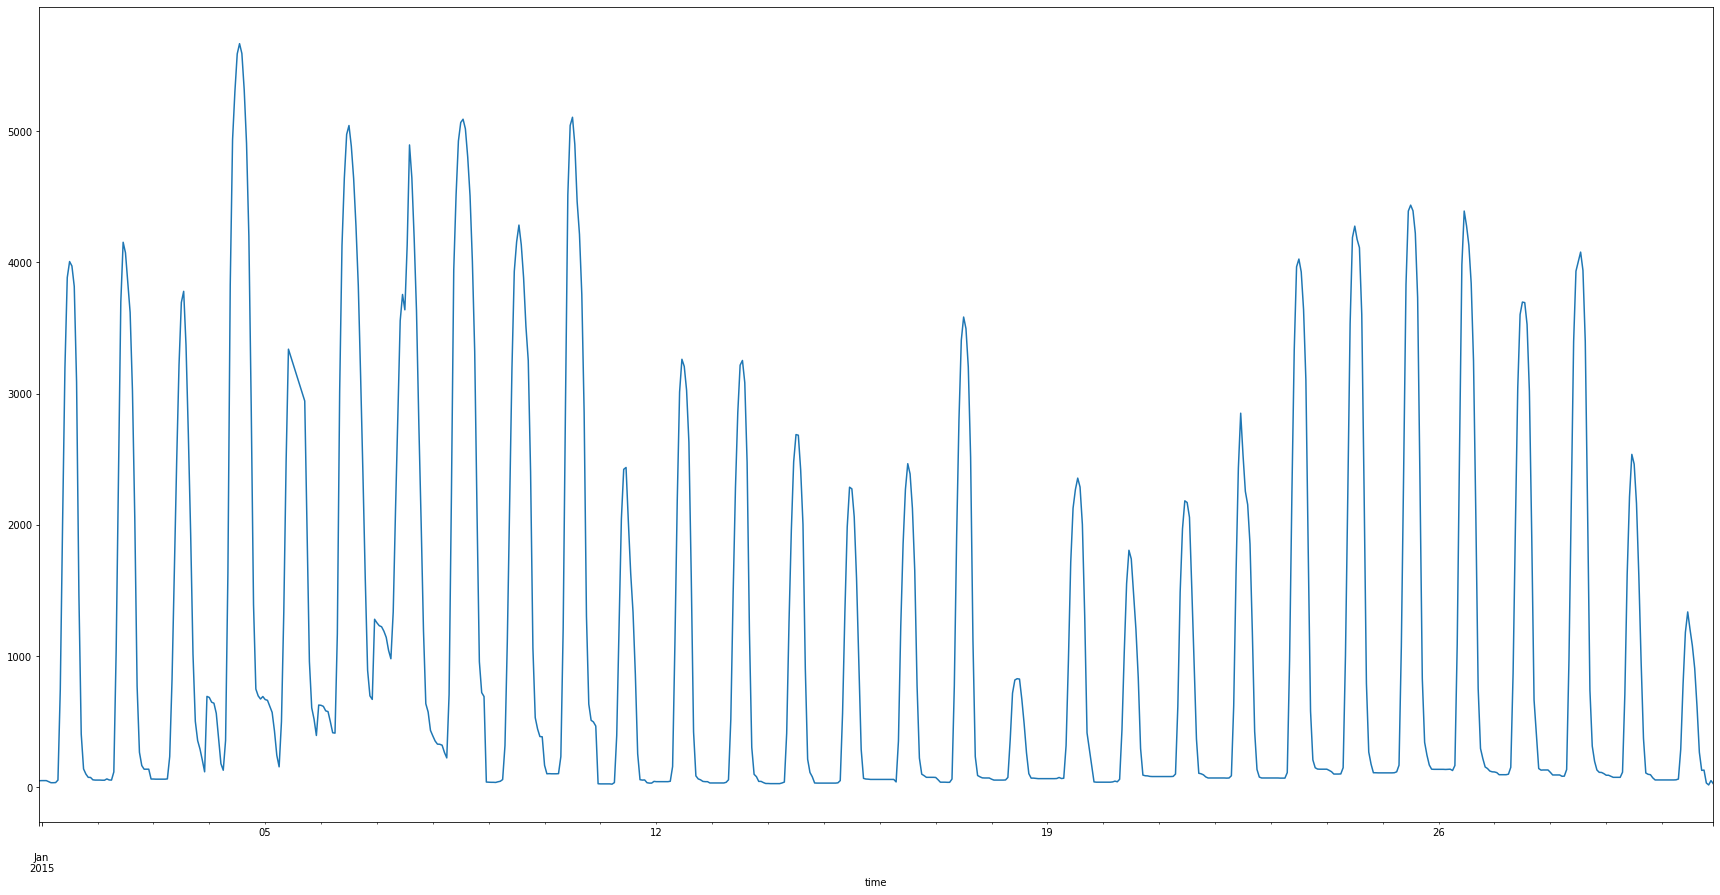

In [7]:
df['generation solar'][:24*30].plot(figsize=(30, 15))

<AxesSubplot:xlabel='time'>

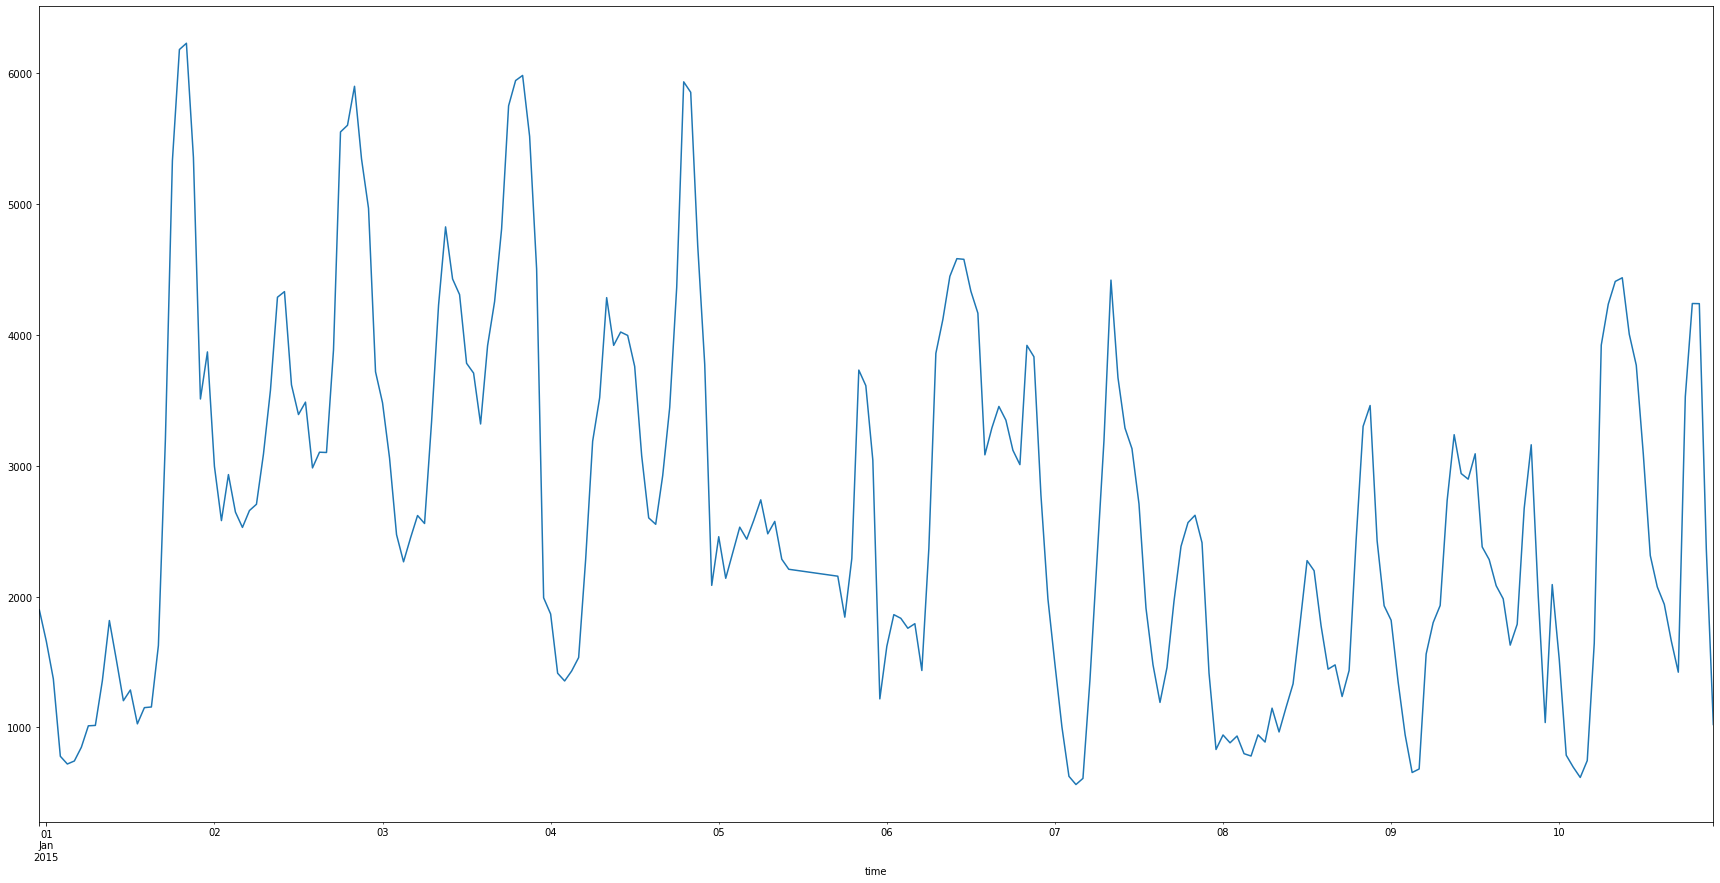

In [8]:
df['generation hydro water reservoir'][:24*10].plot(figsize=(30, 15))

<AxesSubplot:xlabel='time'>

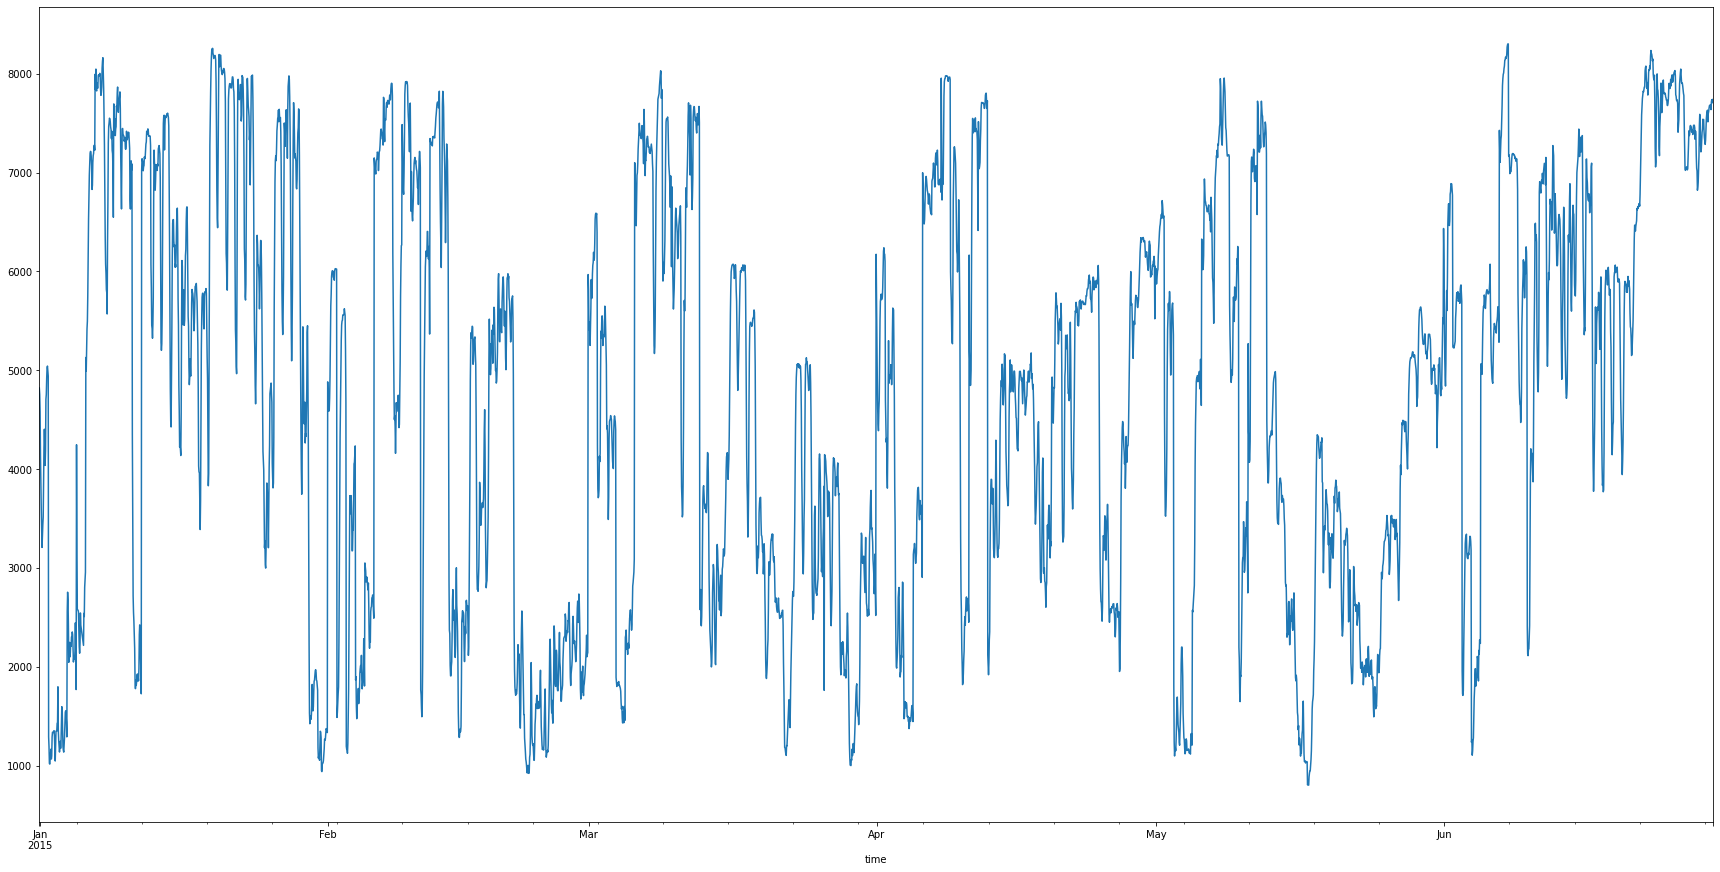

In [9]:
df['generation fossil hard coal'][:24*30*6].plot(figsize=(30, 15))

In [10]:
# Season Periods for every generation type

biomass_season_period               = 30 * 24   # 30 days
nuclear_season_period               = 30 * 24   # 30 days
solar_season_period                 = 1  * 24   # 1 day
fossilHardCoal_season_period        = 30 * 24   # 30 days
hydroWaterResorvoir_season_period   = 1  * 24   # 1 day


Finally lets check the correlation between different generation types

generation biomass  \
generation biomass                          1.000000   
generation hydro water reservoir           -0.033307   
generation fossil hard coal                 0.433734   
generation nuclear                         -0.021053   
generation solar                           -0.004730   

                                  generation hydro water reservoir  \
generation biomass                                       -0.033307   
generation hydro water reservoir                          1.000000   
generation fossil hard coal                              -0.157031   
generation nuclear                                       -0.049237   
generation solar                                          0.091661   

                                  generation fossil hard coal  \
generation biomass                                   0.433734   
generation hydro water reservoir                    -0.157031   
generation fossil hard coal                          1.000000   
generation nuclear                                  -0.023150   
generation solar                                     0.045906   

                                  generation nuclear  generation solar  
generation biomass                         -0.021053         -0.004730  
generation hydro water reservoir           -0.049237          0.091661  
generation fossil hard coal                -0.023150          0.045906  
generation nuclear                          1.000000          0.003911  
generation solar                            0.003911          1.000000

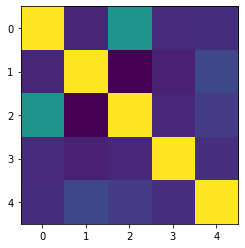

In [11]:
corr = df.corr()
plt.imshow(corr)
corr

We can see that the highest correlation is 43%, which is still not too much so we can assume that all generation types are independent of eachother

# Data Preprocessing

In [12]:
def window(arr, nPast, nFuture):
    '''
    arr: 2D array like object
    nPast: window size of the required feature array
    nFuture: how far in the future the required label is

    takes in a 2d array like object and returns a windowed feature (3d) array and it's corresponding label array (3d)
    '''
    winSize = nFuture + nPast

    data = np.stack([ 
        arr[i:i-winSize]
        for i in range(winSize)
    ]
    ).transpose([1,0,2])

    data = data[
        np.random.permutation(data.shape[0])
    ]

    X = data[:, :nPast,    :].copy()
    y = data[:, -nFuture:, :].copy()

    return X, y


In [13]:
colNames        = df.columns
generationTypes = [ 'biomass', 'hwr', 'fhc', 'nuclear', 'solar' ]

nPast   = 24
nFuture = 1
winSize = nPast + nFuture

num_attr    = 1
input_shape = (nPast, num_attr)

## Splitting Data into Train, Validation and Test sets

In [14]:
train_size = 24 * 365 * 3               # first 3 years of data
val_size   = int(24 * 365 * 0.5)        # first 6 months of last year of data
test_size  = int(24 * 365 * 0.5)        # last 6 months of last year of data

In [15]:
train   = df[:train_size]
val     = df[train_size: train_size + val_size]
test    = df[train_size + val_size:]

In [16]:
print(f'''
    Total data is {len(df)    // (24*365)} years
    Training is   {len(train) // (24*365)} years of data 
    Validation is {len(val)   /  (24*365)} years of data
    Testing is    {len(test)  /  (24*365)} years of data
''')


    Total data is 4 years
    Training is   3 years of data 
    Validation is 0.5 years of data
    Testing is    0.5027397260273972 years of data



# Neural Networks

In [54]:
loss    = tf.keras.losses.MeanSquaredError()
metrics = [RootMeanSquaredError(), MeanAbsoluteError()]

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#                 lambda epoch: 1e-3 * 10**(epoch / 10)
            #   )
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [31]:
def plot_save_history(history, path):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error'][1:]
    val_rmse = history.history['val_root_mean_squared_error'][1:]

    train_mae = history.history['mean_absolute_error'][1:]
    val_mae = history.history['val_mean_absolute_error'][1:]
    
    train_loss = history.history['loss'][1:]
    val_loss = history.history['val_loss'][1:]
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(30, 10))
    plt.subplot(1, 3, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 3, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.subplot(1, 3, 3)
    plt.plot(train_mae, label='Training MAE')
    plt.plot(val_mae, label='Validation MAE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation MAE')
    
    plt.savefig(path)
    plt.show()

## Creating Datasets and Scalers

In [42]:
def transform(train, val, test):

    train       = train.values
    val         = val.values
    test        = test.values

    train       = np.expand_dims(train, axis=-1)
    val         = np.expand_dims(val, axis=-1)
    test        = np.expand_dims(test, axis=-1)

    scaler      = MinMaxScaler().fit(train)

    train_norm  = scaler.transform(train)
    val_norm    = scaler.transform(val)
    test_norm   = scaler.transform(test)

    X_train , y_train = window(train_norm, solar_season_period, 1)
    X_val   , y_val   = window(val_norm, solar_season_period, 1)
    X_test  , y_test  = window(test_norm, solar_season_period, 1)

    return scaler, {
        'train' : { 'x': X_train, 'y': y_train },
        'val'   : { 'x': X_val  , 'y': y_val   },
        'test'  : { 'x': X_test , 'y': y_test  },
    }

In [43]:
temp = [
    transform(train[colName], val[colName], test[colName])
    for colName in colNames
]

# a dictionery of our scalers
scalers  = {}

# a dictionary of preprocessed datasets
datasets = {}

for type, (scaler, dataset) in zip(generationTypes, temp):
    scalers[type] = scaler
    datasets[type] = dataset    

## LSTM

### Creating models

In [35]:
lstm_models = {}

for type in generationTypes:
    
    model = tf.keras.Sequential([
        LSTM(100, input_shape=input_shape, return_sequences=True),
        Flatten(),
        Dense(200, activation='relu'),
        Dropout(0.1),
        Dense(num_attr)
    ],
        name= f'lstm_{type}'
    )

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'models/lstm_{type}.h5', monitor=('val_loss'), save_best_only=True)
    optimizer        = tf.keras.optimizers.Adam(learning_rate=6e-2, amsgrad=True)

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    lstm_models[type] = model

    


### Displaying models

In [36]:
for type, model in lstm_models.items():
    print()
    print('='*100)
    print(f'the model for {type} generation: ')
    model.summary()


the model for biomass generation: 
Model: "lstm_biomass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 100)           40800     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               480200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 521,201
Trainable params: 521,201
Non-trainable params: 0
_________________________________________________________________

the model for hwr generation: 
Model: "lstm_hwr"
____________________________

### training models

In [37]:
lstm_models_history = {}

for type in generationTypes:
    tf.keras.backend.clear_session()            ## Clearing session to avoid any discrepency


    model   = lstm_models[type]

    X_train = datasets[type]['train']['x']
    y_train = datasets[type]['train']['y']
    
    X_val   = datasets[type]['val']['x']
    y_val   = datasets[type]['val']['y']
    
    history = model.fit(
        X_train, y_train, 
        epochs          = 5,
        validation_data = ( X_val, y_val ),
        callbacks       = [early_stopping, model_checkpoint]
    )
    lstm_models_history[type] = history

Epoch 1/5
821/821 [==============================] - 44s 51ms/step - loss: 257.4861 - root_mean_squared_error: 11.9306 - mean_absolute_error: 0.9729 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1410 - val_mean_absolute_error: 0.1163
Epoch 2/5
821/821 [==============================] - 42s 51ms/step - loss: 0.0342 - root_mean_squared_error: 0.1850 - mean_absolute_error: 0.1499 - val_loss: 0.0275 - val_root_mean_squared_error: 0.1660 - val_mean_absolute_error: 0.1460
Epoch 3/5
821/821 [==============================] - 41s 49ms/step - loss: 0.0320 - root_mean_squared_error: 0.1789 - mean_absolute_error: 0.1452 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1356 - val_mean_absolute_error: 0.1114
Epoch 4/5
821/821 [==============================] - 41s 50ms/step - loss: 0.0288 - root_mean_squared_error: 0.1697 - mean_absolute_error: 0.1380 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1299 - val_mean_absolute_error: 0.1054
Epoch 5/5
821/821 [==============================

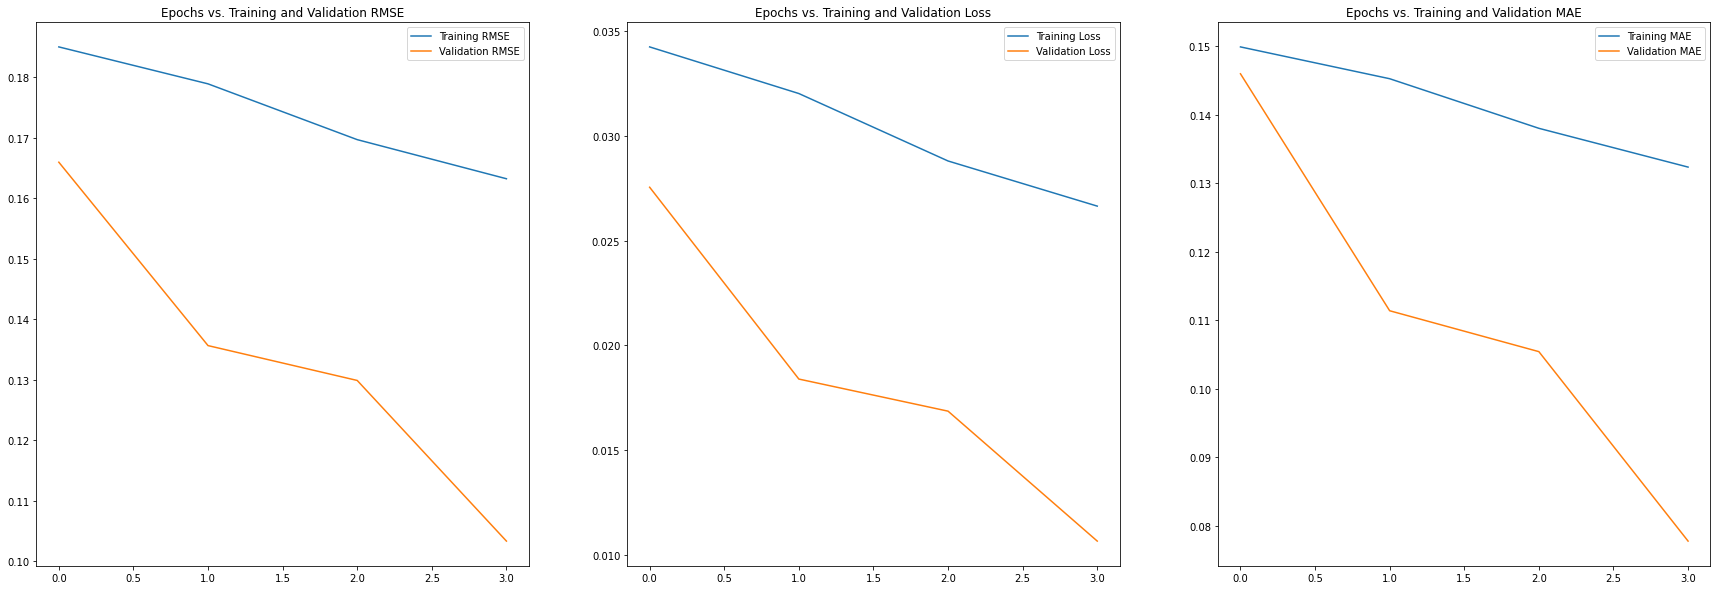

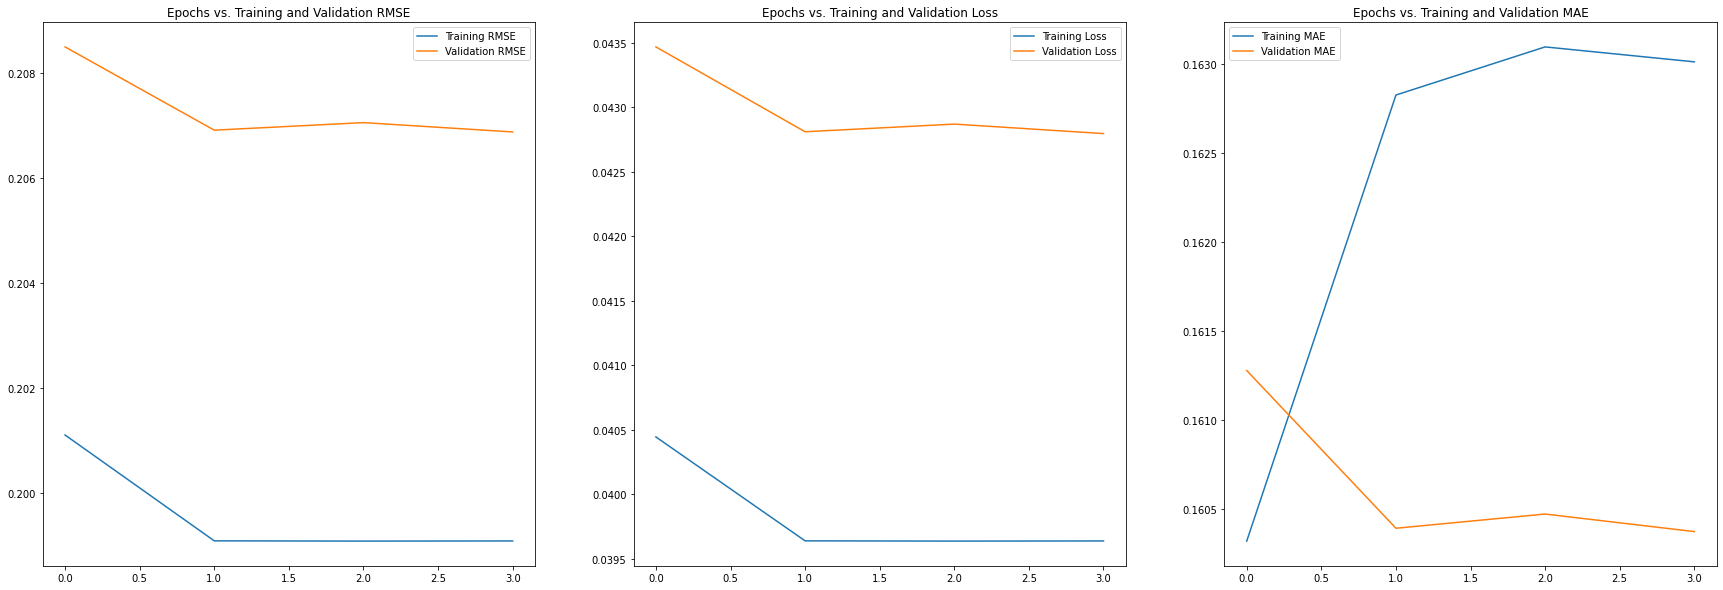

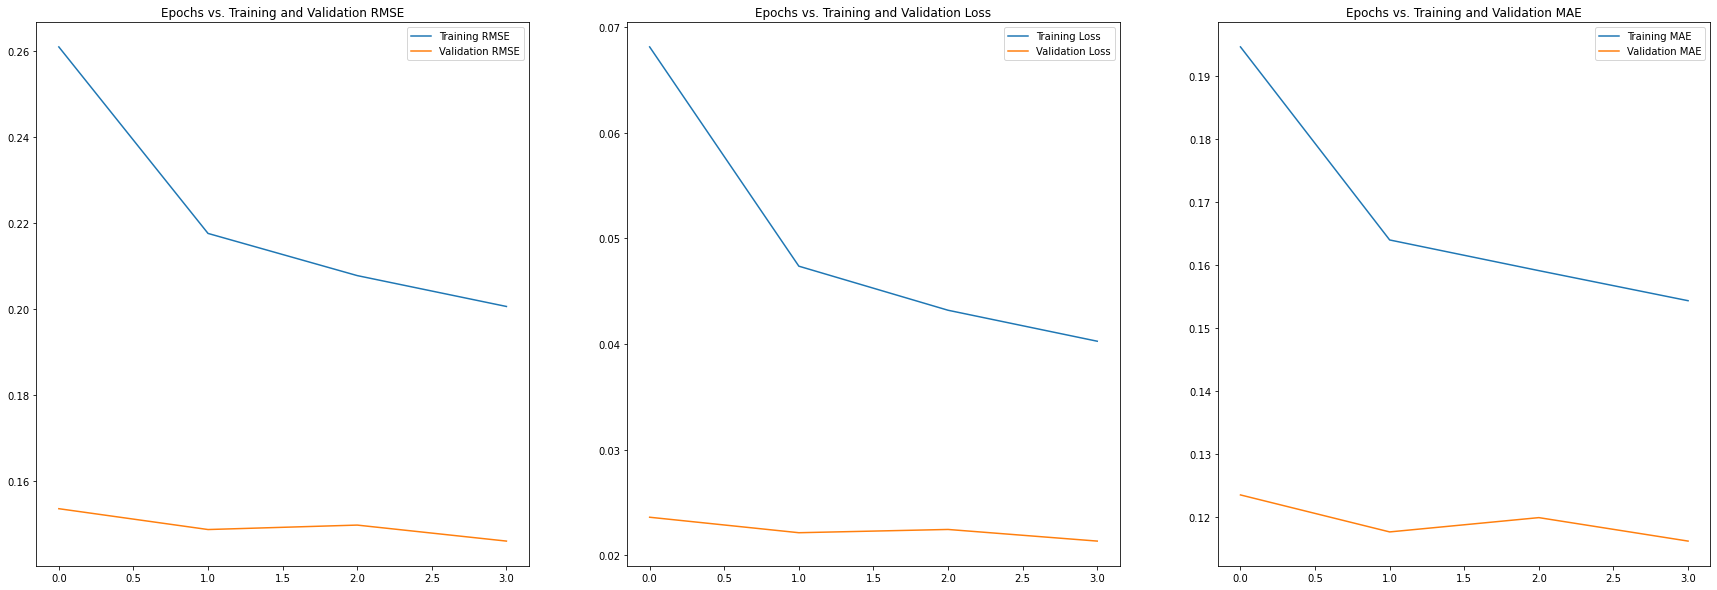

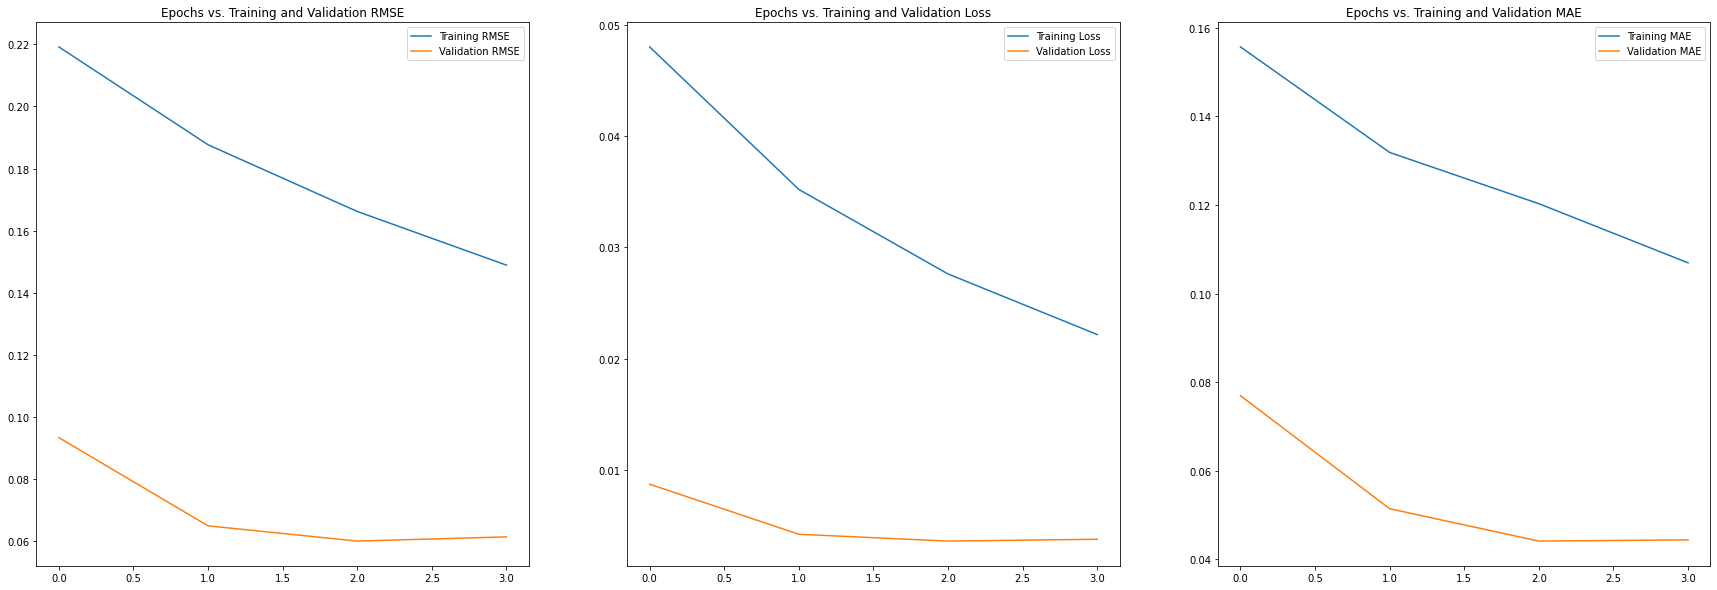

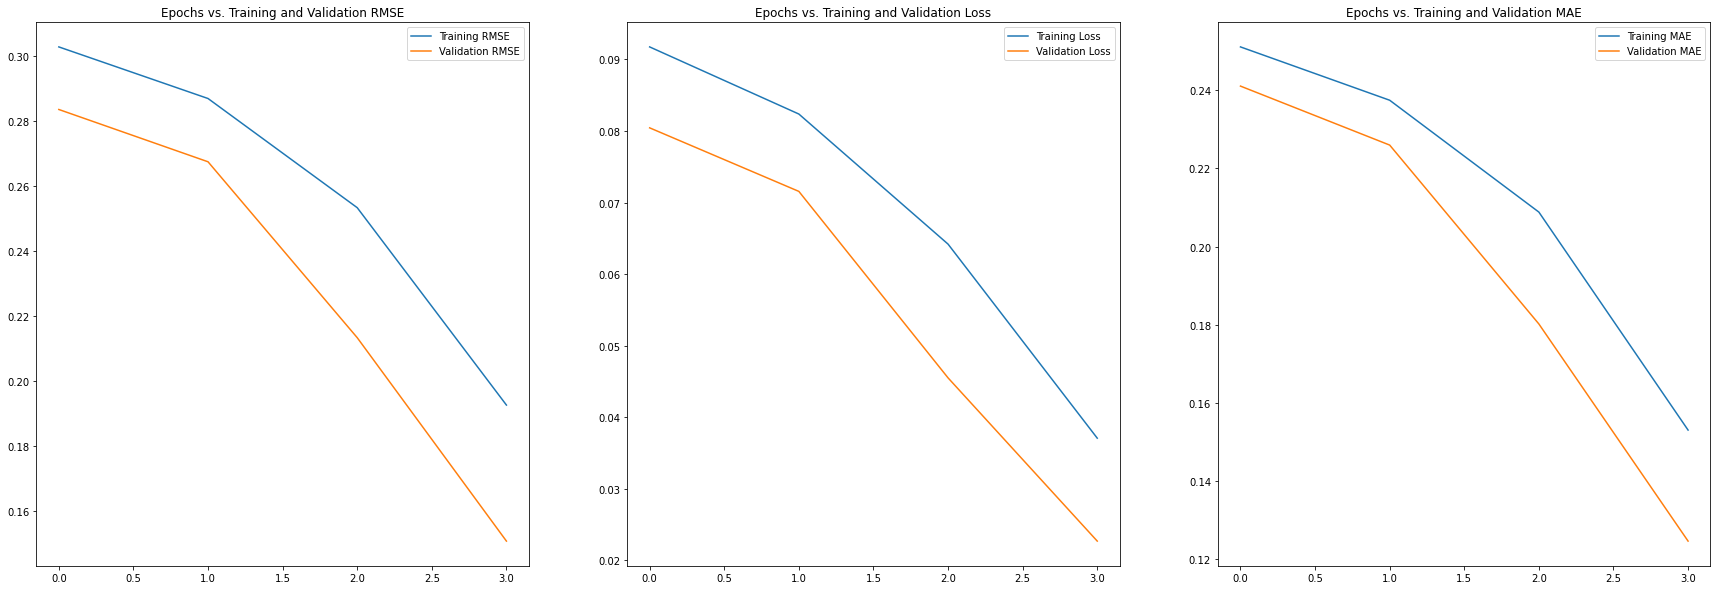

In [39]:
for type, history in lstm_models_history.items():

    plot_save_history(history, f'history/lstm_{type}_history')

### saving models

In [54]:
for type, model in lstm_models.items():
    model.save(f'models/lstm_{type}.h5')

### evaluation

In [84]:
lstm_models = {
    'solar': tf.keras.models.load_model('models/lstm_solar.h5'),
    'nuclear': tf.keras.models.load_model('models/lstm_nuclear.h5'),
    'biomass': tf.keras.models.load_model('models/lstm_biomass.h5'),
    'hwr': tf.keras.models.load_model('models/lstm_hwr.h5'),
    'fhc': tf.keras.models.load_model('models/lstm_fhc.h5'),
}

In [91]:
lstm_preds = {}
for type in generationTypes:

    model = lstm_models[type]
    
    X_test = datasets[type]['test']['x']
    y_test = datasets[type]['test']['y']

    evals[f'lstm_{type}'] = model.evaluate(X_test, y_test)
    lstm_preds[type] = model.predict(X_test)

137/137 [==============================] - 4s 32ms/step - loss: 0.0014 - root_mean_squared_error: 0.0377 - mean_absolute_error: 0.0292


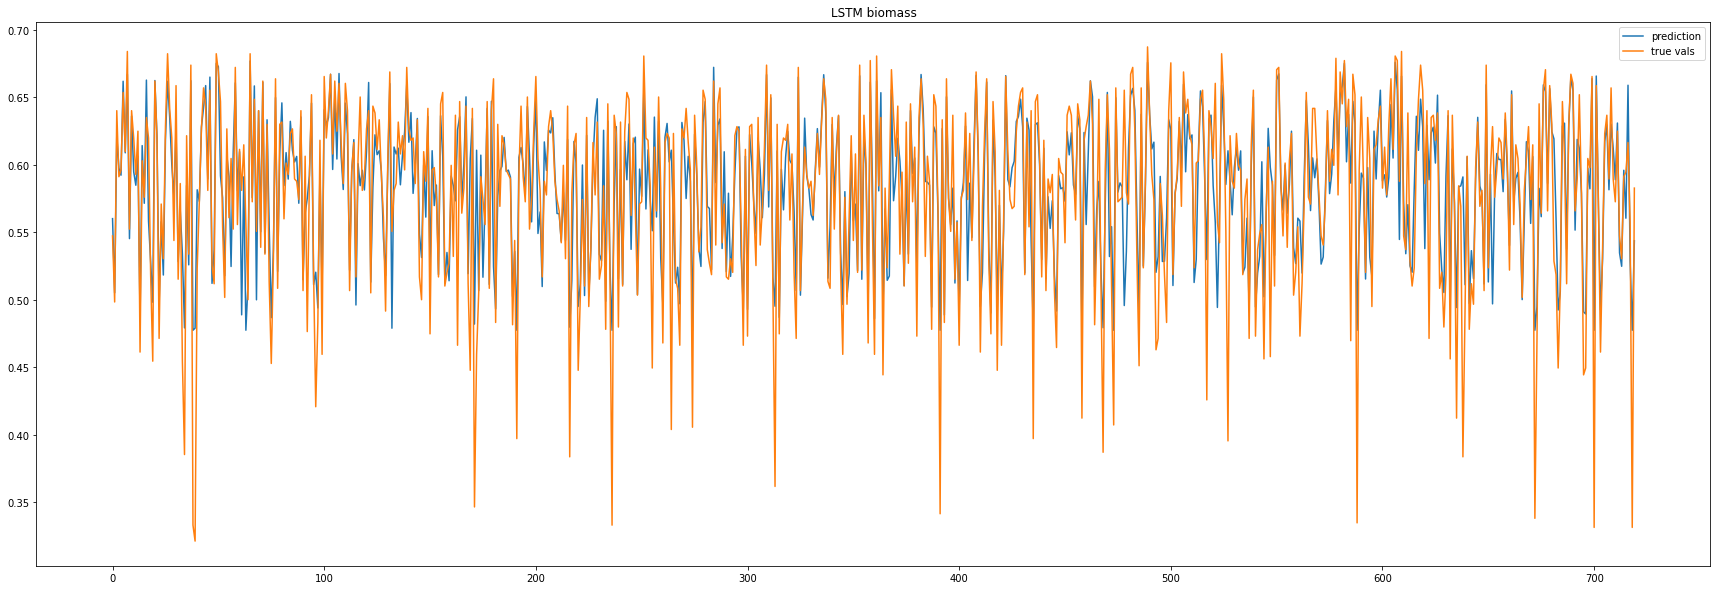

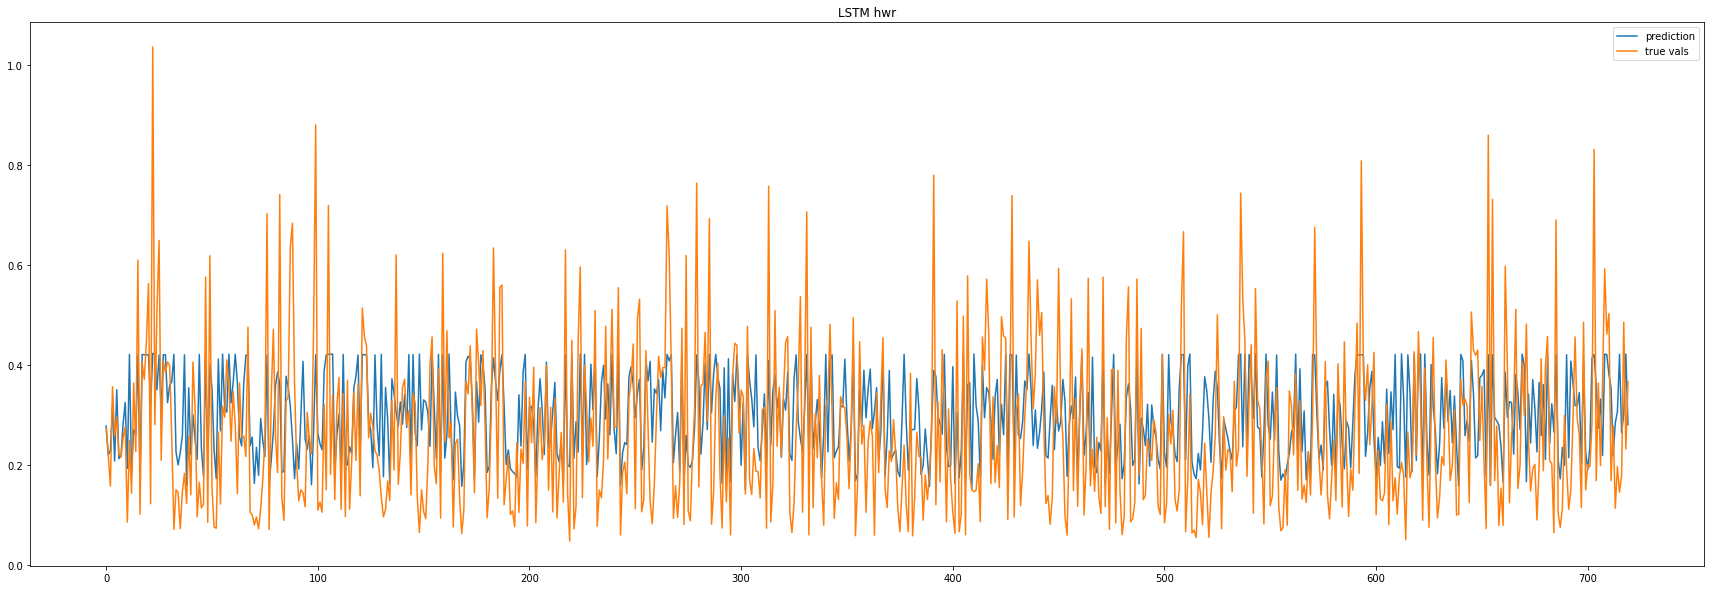

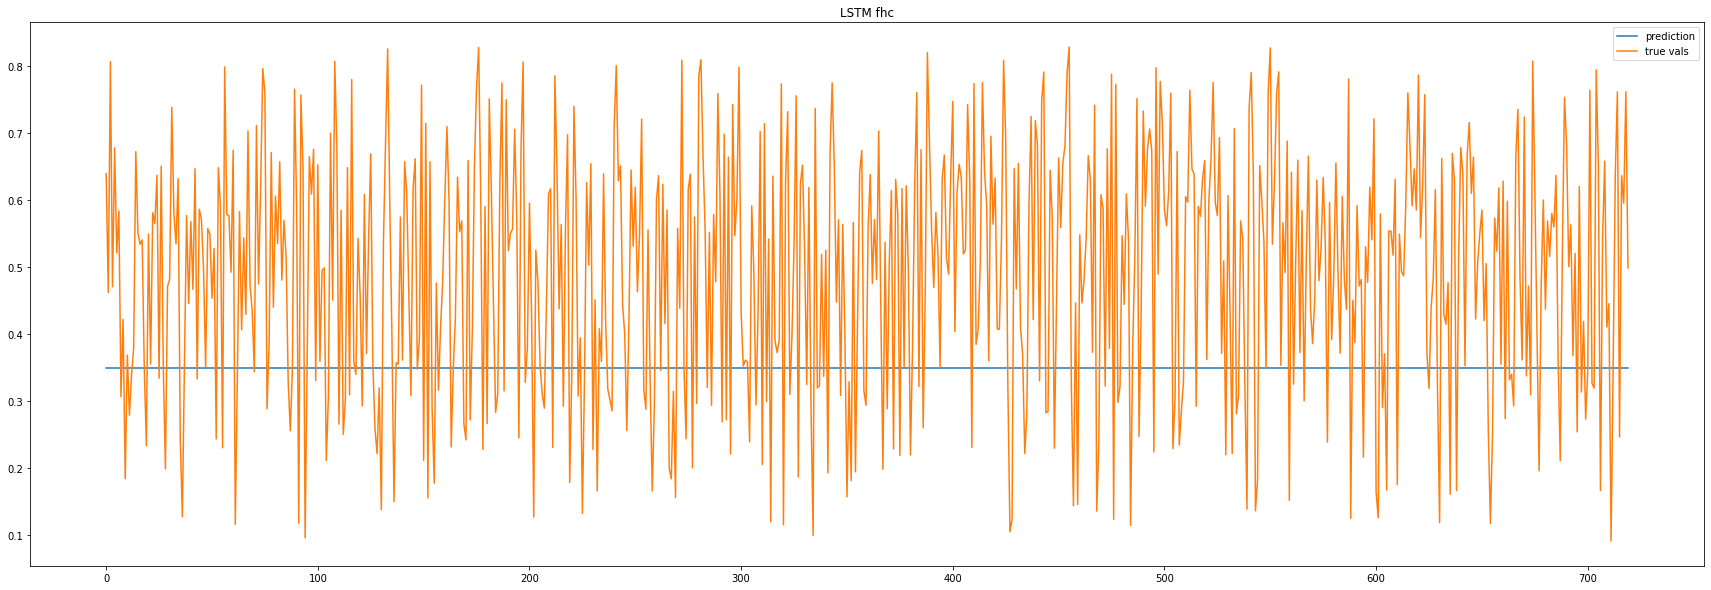

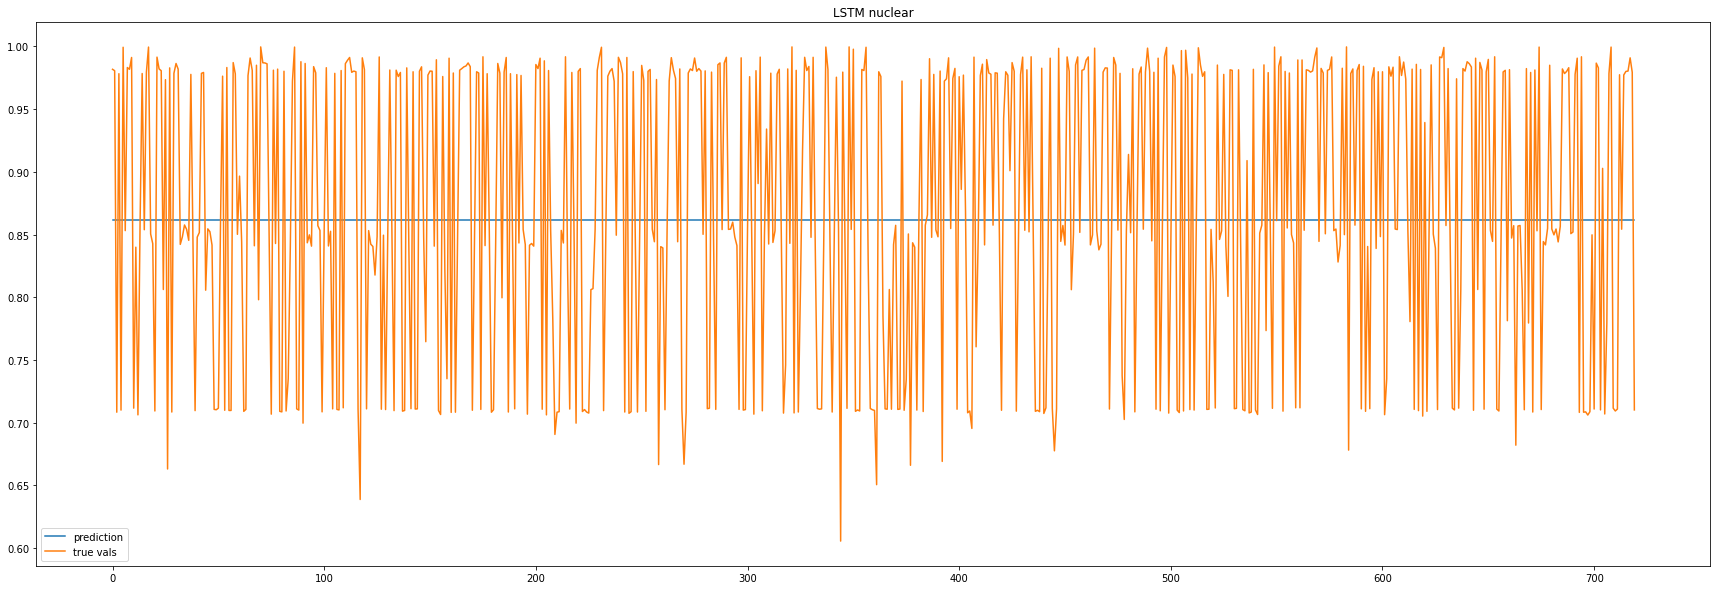

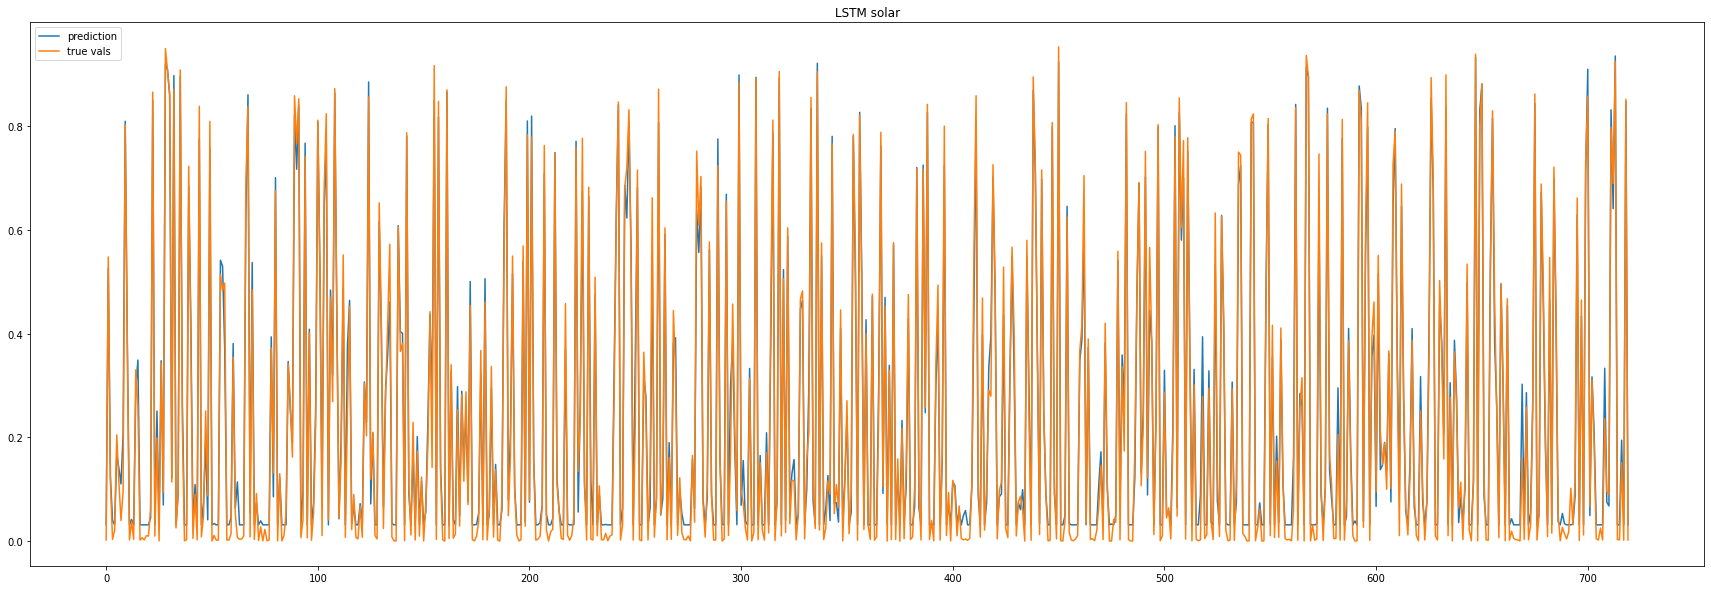

In [92]:
for type in generationTypes:

    p = lstm_preds[type][:24*30]
    y = datasets[type]['test']['y'].ravel()[:24*30]

    plt.figure(figsize= (30,10))
    plt.title(f'LSTM {type}')
    plt.plot(p, label= 'prediction')
    plt.plot(y, label= 'true vals')
    plt.legend()
    plt.savefig(f'evaluation/lstm_{type}_evaluation.png')
    plt.show()


## CNN-LSTM

### Creating models

In [62]:
cnn_lstm_models = {}

for type in generationTypes:
    
    model = tf.keras.models.Sequential([
        Conv1D(filters=100, kernel_size=2, strides=1, padding='causal', activation='relu', input_shape=input_shape),
        LSTM(100, return_sequences=True),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(num_attr)
    ])

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'models/cnn_lstm_{type}.h5', monitor=('val_loss'), save_best_only=True)
    optimizer        = tf.keras.optimizers.Adam(learning_rate=6e-2, amsgrad=True)

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    cnn_lstm_models[type] = model

### Displaying models

In [47]:
for type, model in cnn_lstm_models.items():
    print()
    print('='*100)
    print(f'the model for {type} generation: ')
    model.summary()


the model for biomass generation: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24, 100)           300       
_________________________________________________________________
lstm (LSTM)                  (None, 24, 100)           80400     
_________________________________________________________________
flatten (Flatten)            (None, 2400)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                120050    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 200,801
Trainable params: 200,801
Non-trainable params: 0
_________________________________________________________________

the model for hwr generation: 
Model: "sequential_1"
__________________________

### training models

In [ ]:
cnn_lstm_models_history = {}

for type in generationTypes:
    tf.keras.backend.clear_session()            ## Clearing session to avoid any discrepency


    model   = cnn_lstm_models[type]

    X_train = datasets[type]['train']['x']
    y_train = datasets[type]['train']['y']
    
    X_val   = datasets[type]['val']['x']
    y_val   = datasets[type]['val']['y']
    
    history = model.fit(
        X_train, y_train, 
        epochs          = 2,
        validation_data = ( X_val, y_val ),
        callbacks       = [early_stopping, model_checkpoint]
    )
    cnn_lstm_models_history[type] = history


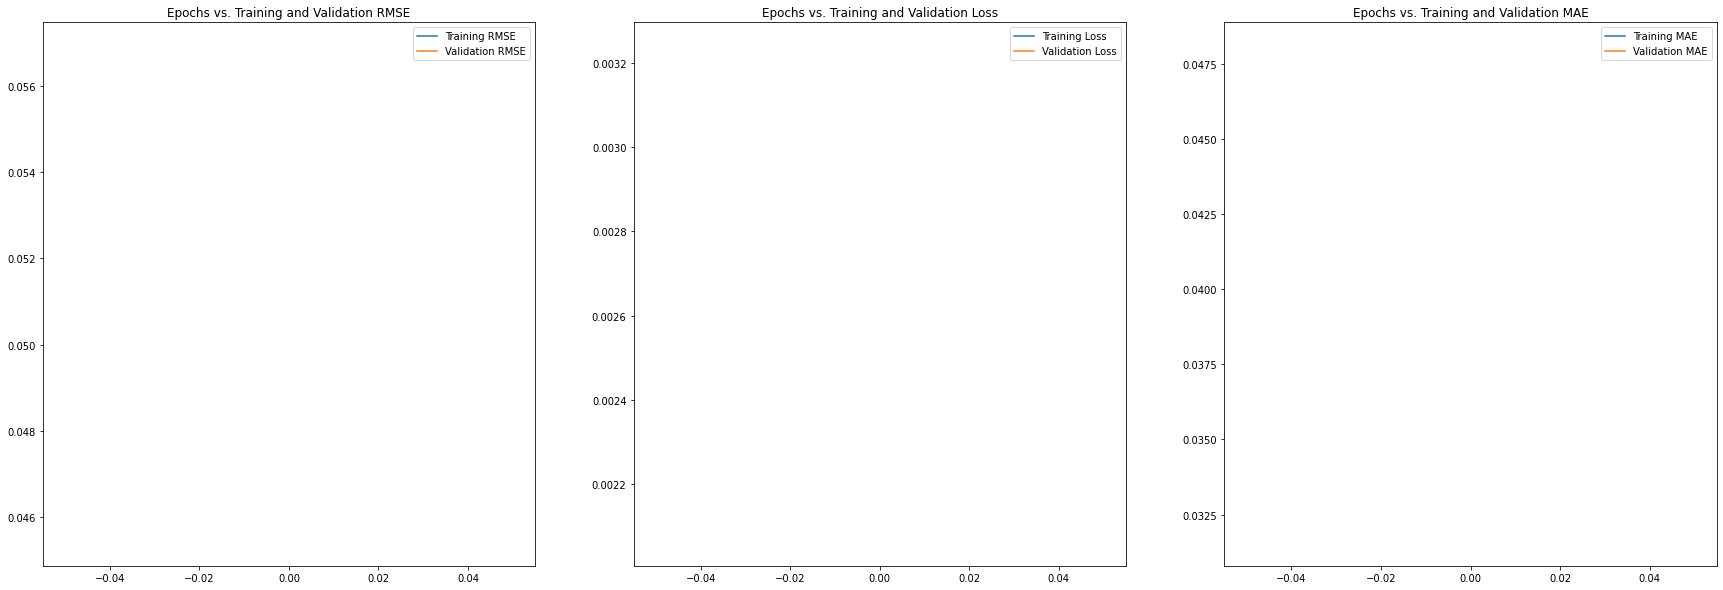

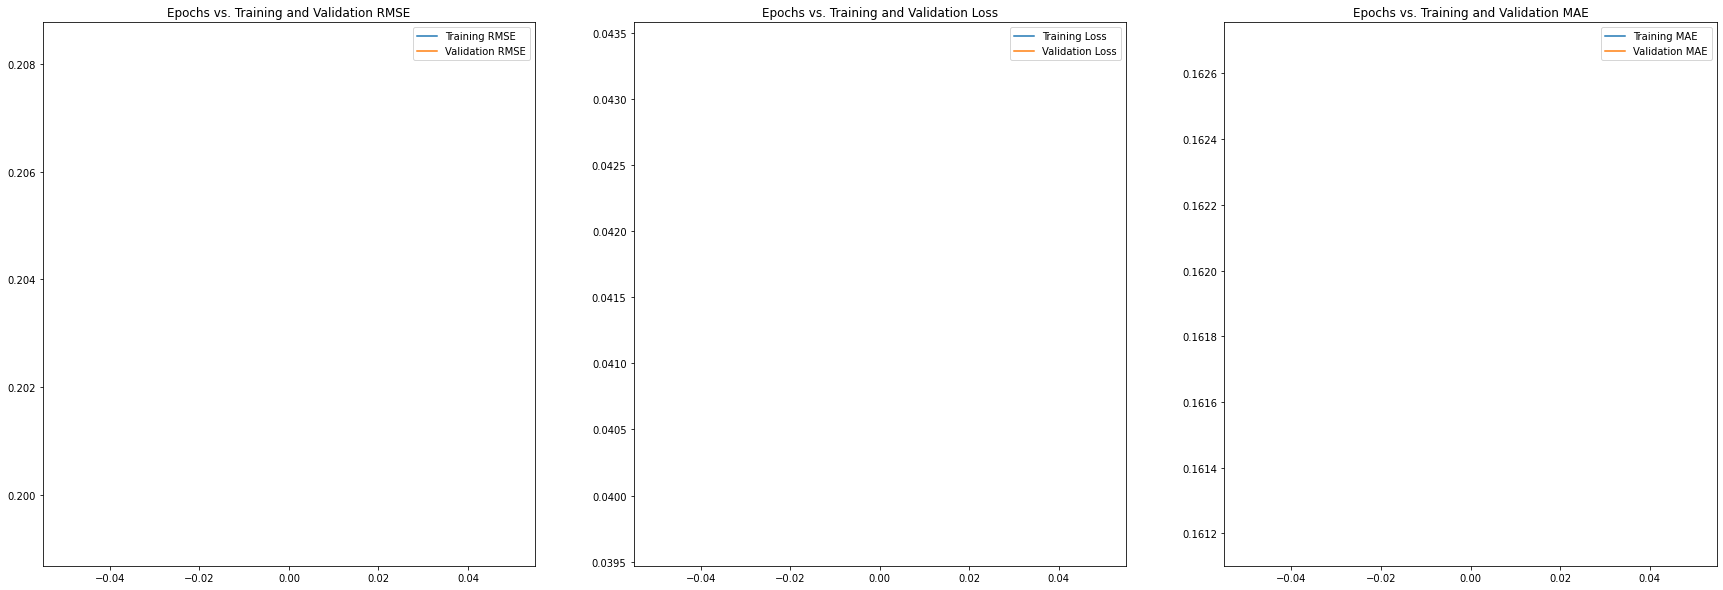

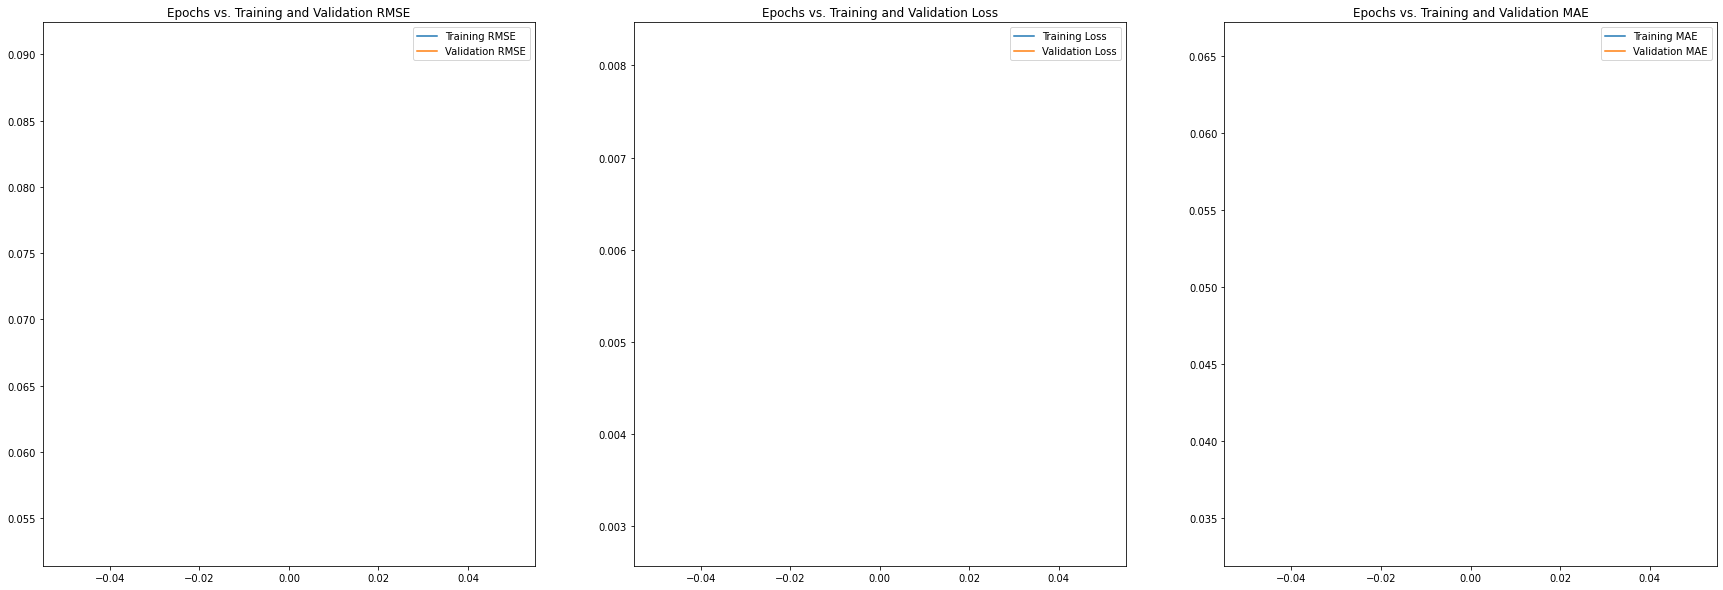

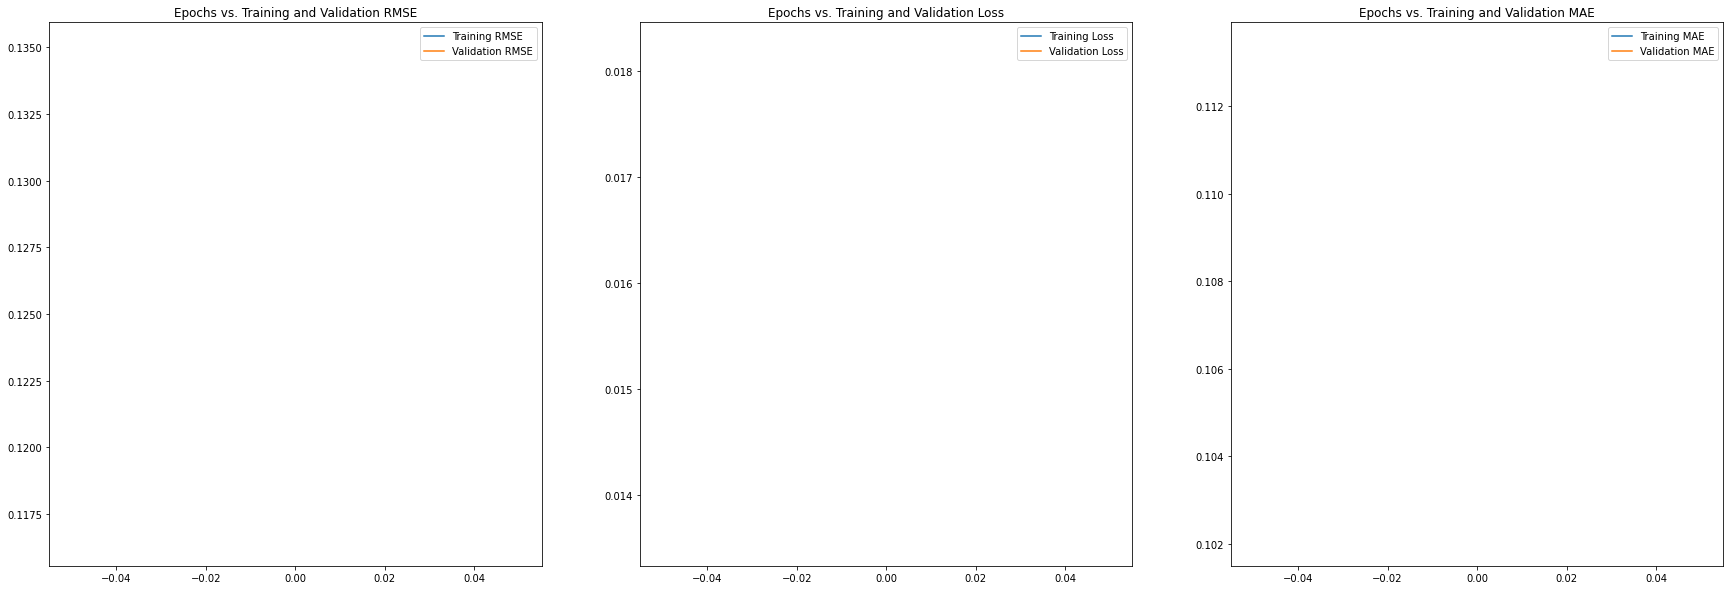

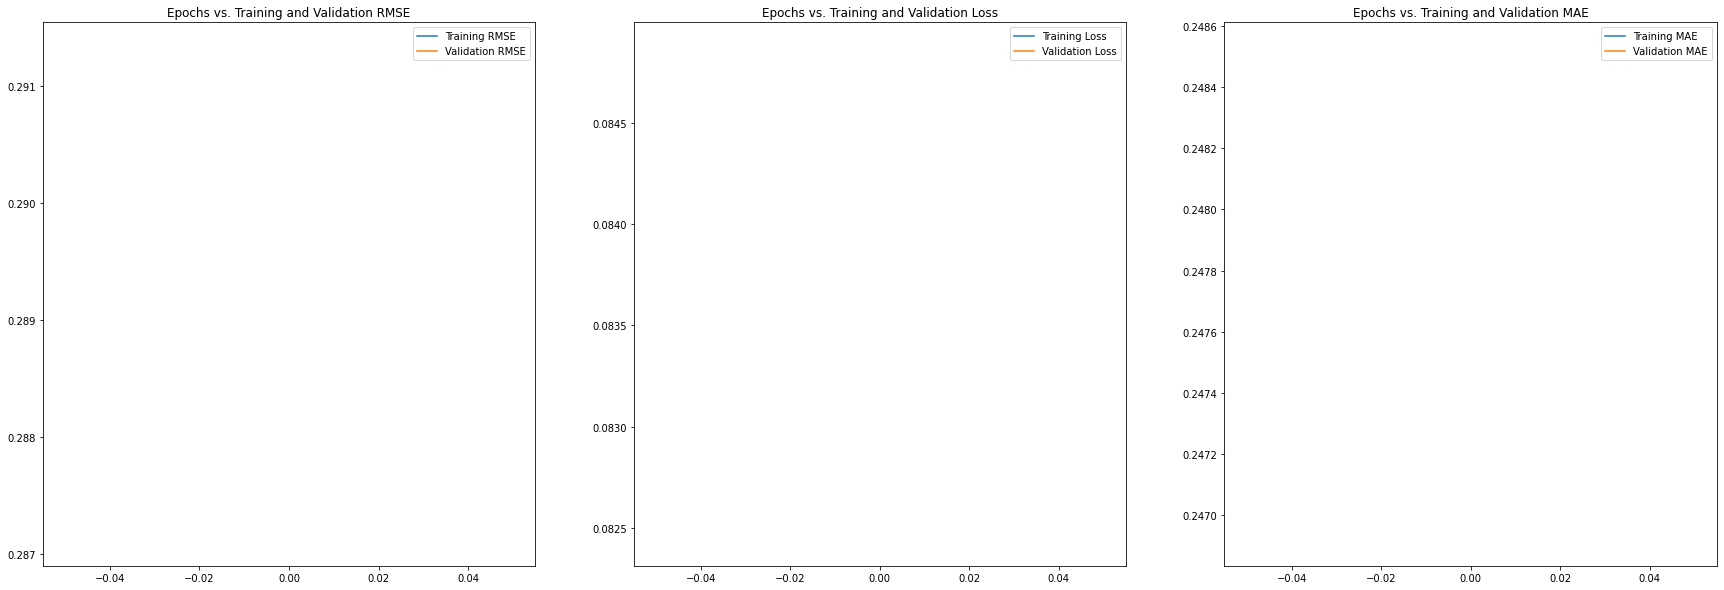

In [ ]:
for type, history in cnn_lstm_models_history.items():

    plot_save_history(history, f'history/cnn_lstm_{type}_history')

### saving models

In [ ]:
for type, model in cnn_lstm_models.items():
    model.save(f'models/cnn_lstm_{type}.h5')

### evaluation

In [87]:
cnn_lstm_models = {
    'solar': tf.keras.models.load_model('models/cnn_lstm_solar.h5'),
    'nuclear': tf.keras.models.load_model('models/cnn_lstm_nuclear.h5'),
    'biomass': tf.keras.models.load_model('models/cnn_lstm_biomass.h5'),
    'hwr': tf.keras.models.load_model('models/cnn_lstm_hwr.h5'),
    'fhc': tf.keras.models.load_model('models/cnn_lstm_fhc.h5'),
}

In [93]:
cnn_lstm_preds = {}
for type in generationTypes:

    model = cnn_lstm_models[type]
    
    X_test = datasets[type]['test']['x']
    y_test = datasets[type]['test']['y']

    evals[f'cnn_lstm_{type}'] = model.evaluate(X_test, y_test)
    cnn_lstm_preds[type] = model.predict(X_test)

137/137 [==============================] - 3s 22ms/step - loss: 0.0820 - root_mean_squared_error: 0.2864 - mean_absolute_error: 0.2447


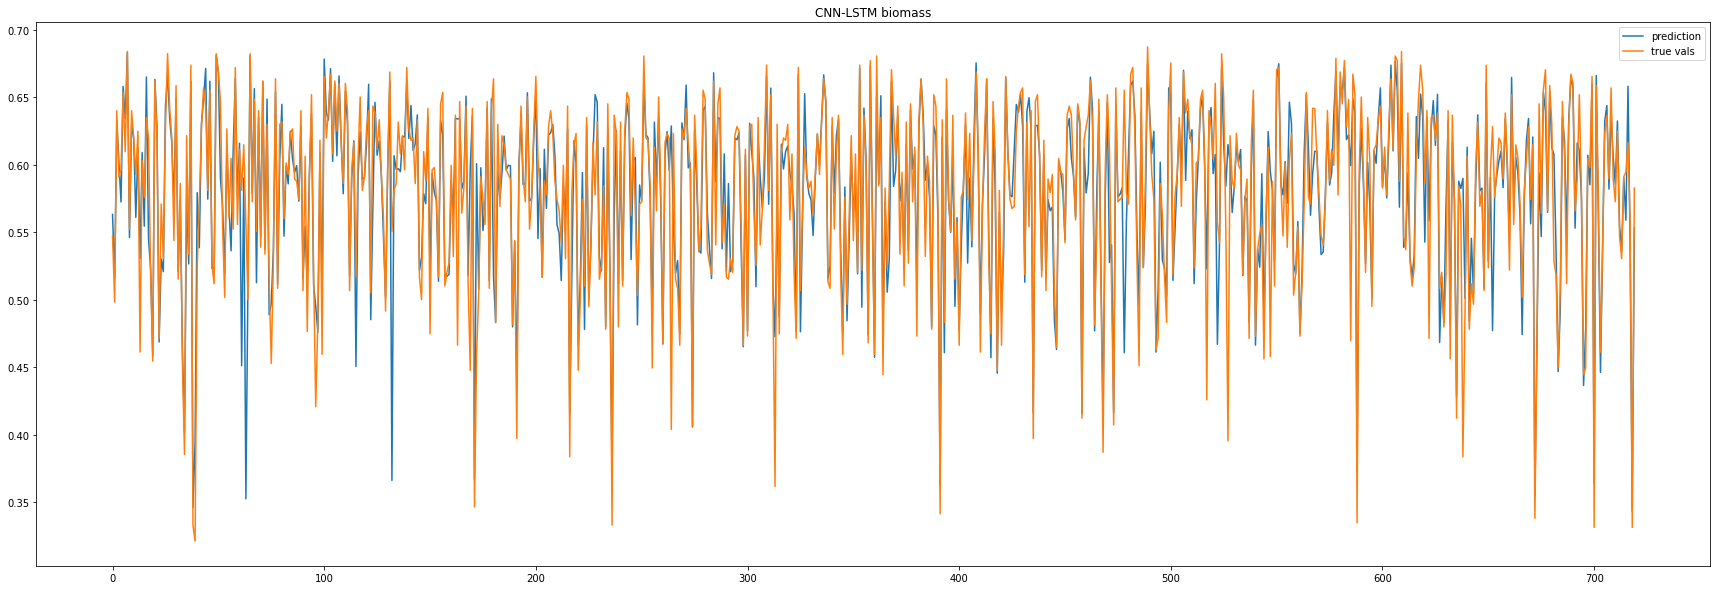

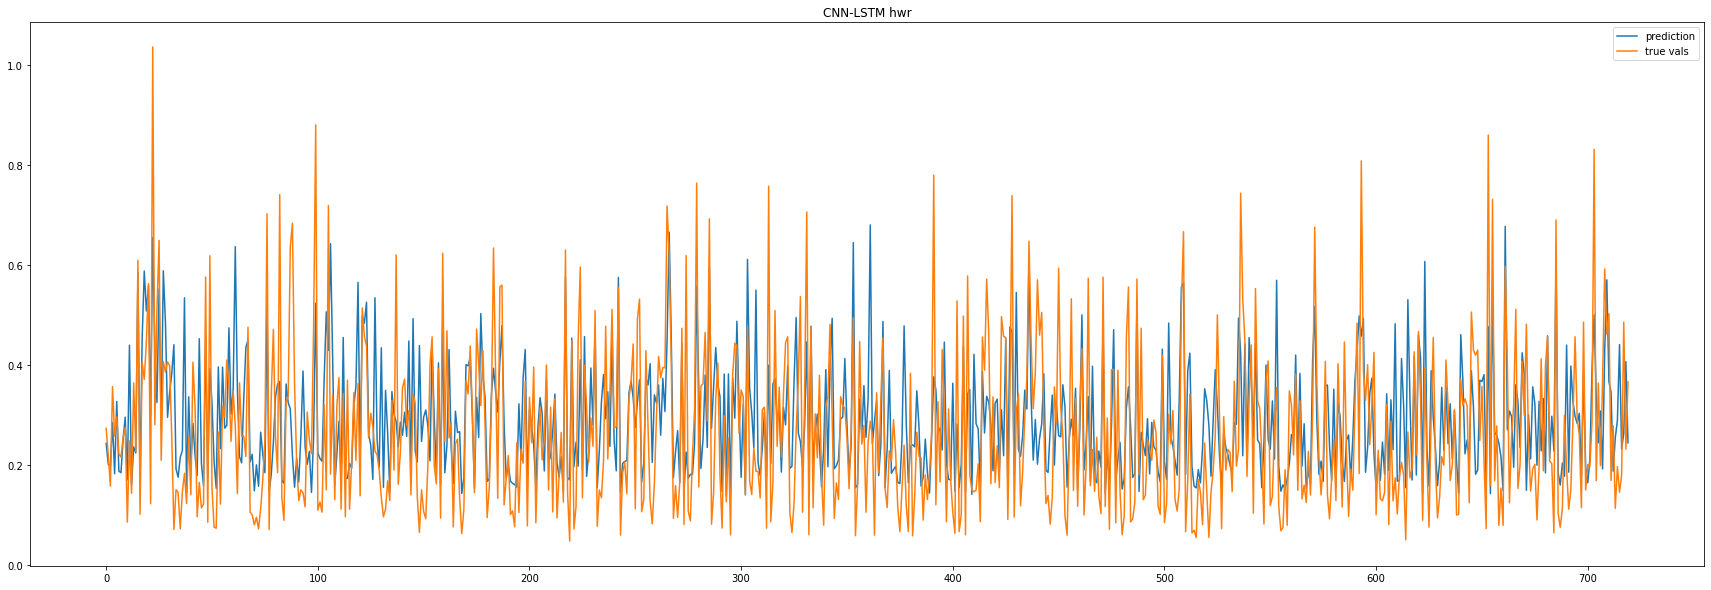

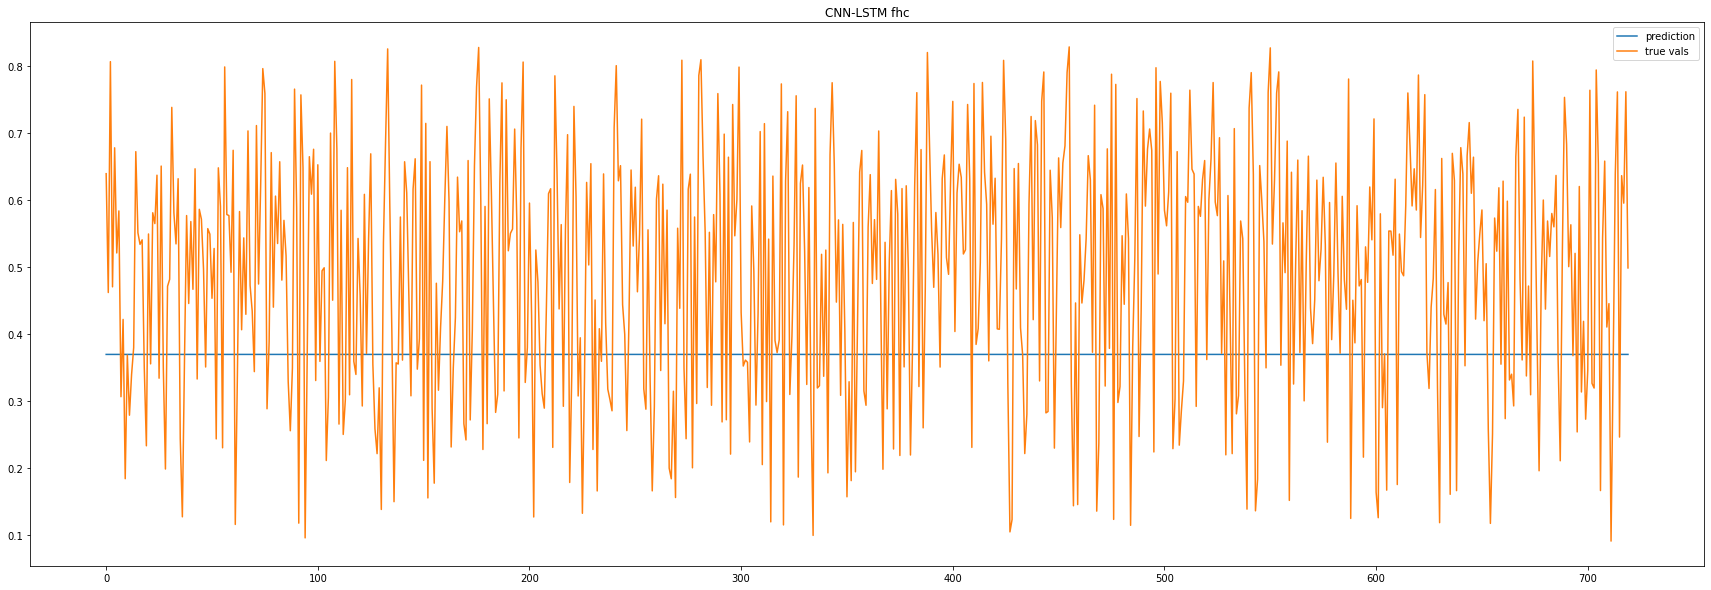

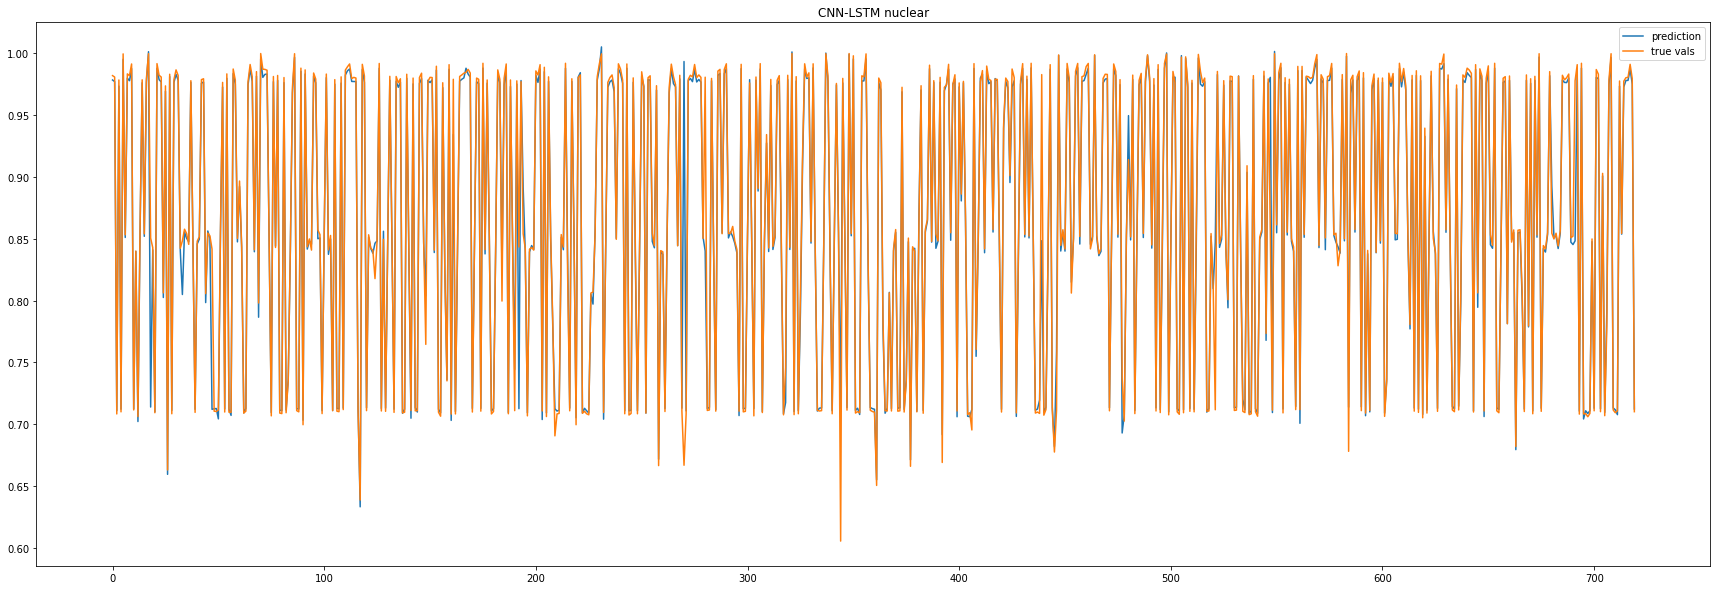

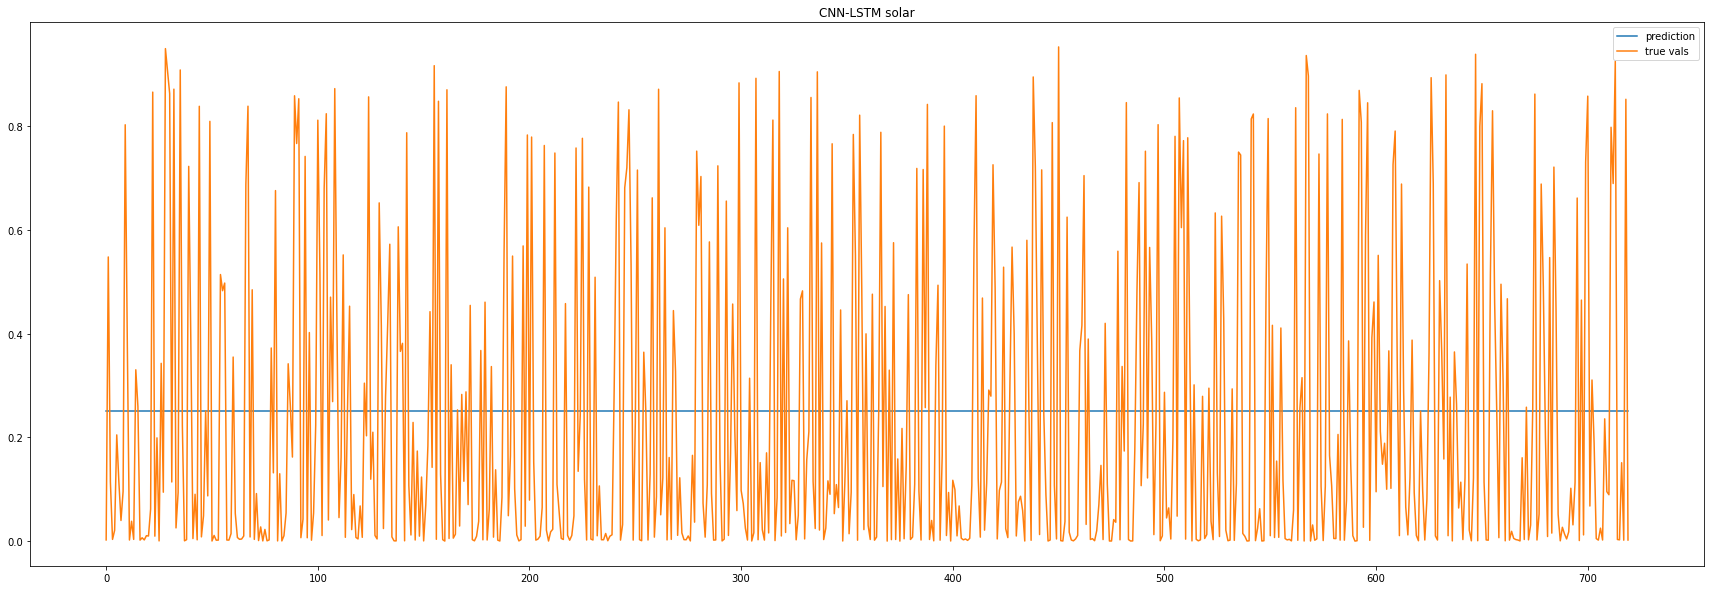

In [89]:
for type in generationTypes:

    p = cnn_lstm_preds[type][:24*30]
    y = datasets[type]['test']['y'].ravel()[:24*30]

    plt.figure(figsize= (30,10))
    plt.title(f'CNN-LSTM {type}')
    plt.plot(p, label= 'prediction')
    plt.plot(y, label= 'true vals')
    plt.legend()
    plt.savefig(f'evaluation/cnn_lstm_{type}_evaluation.png')
    plt.show()


## Stacked-LSTMs

### Creating models

In [34]:
stacked_lstm_models = {}

for type in generationTypes:
    
    model = tf.keras.models.Sequential([
                        LSTM(100, input_shape=input_shape, return_sequences=True),
                        LSTM(50, return_sequences=True),
                        Flatten(),
                        Dense(150, activation='relu'),
                        Dropout(0.1),
                        Dense(num_attr)
])

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'models/stacked_lstm_{type}.h5', monitor=('val_loss'), save_best_only=True)
    optimizer        = tf.keras.optimizers.Adam(learning_rate=6e-2, amsgrad=True)

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    stacked_lstm_models[type] = model

### Displaying models

In [35]:
for type, model in stacked_lstm_models.items():
    print()
    print('='*100)
    print(f'the model for {type} generation: ')
    model.summary()


the model for biomass generation: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 50)            30200     
_________________________________________________________________
flatten (Flatten)            (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 150)               180150    
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 251,301
Trainable params: 251,301
Non-trainable params: 0
______________

### training models

In [36]:
stacked_lstm_models_history = {}

for type in generationTypes:
    tf.keras.backend.clear_session()            ## Clearing session to avoid any discrepency


    model   = stacked_lstm_models[type]

    X_train = datasets[type]['train']['x']
    y_train = datasets[type]['train']['y']
    
    X_val   = datasets[type]['val']['x']
    y_val   = datasets[type]['val']['y']
    
    history = model.fit(
        X_train, y_train, 
        epochs          = 120,
        validation_data = ( X_val, y_val ),
        callbacks       = [early_stopping, model_checkpoint]
    )
    stacked_lstm_models_history[type] = history


Epoch 1/120
821/821 [==============================] - 44s 48ms/step - loss: 31.8555 - root_mean_squared_error: 5.6441 - mean_absolute_error: 0.8466 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0717 - val_mean_absolute_error: 0.0533
Epoch 2/120
821/821 [==============================] - 38s 46ms/step - loss: 0.0105 - root_mean_squared_error: 0.1024 - mean_absolute_error: 0.0766 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0708 - val_mean_absolute_error: 0.0520
Epoch 3/120
821/821 [==============================] - 39s 48ms/step - loss: 0.0089 - root_mean_squared_error: 0.0941 - mean_absolute_error: 0.0699 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0721 - val_mean_absolute_error: 0.0518
Epoch 4/120
821/821 [==============================] - 38s 46ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884 - mean_absolute_error: 0.0644 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0719 - val_mean_absolute_error: 0.0510
Epoch 5/120
821/821 [======================

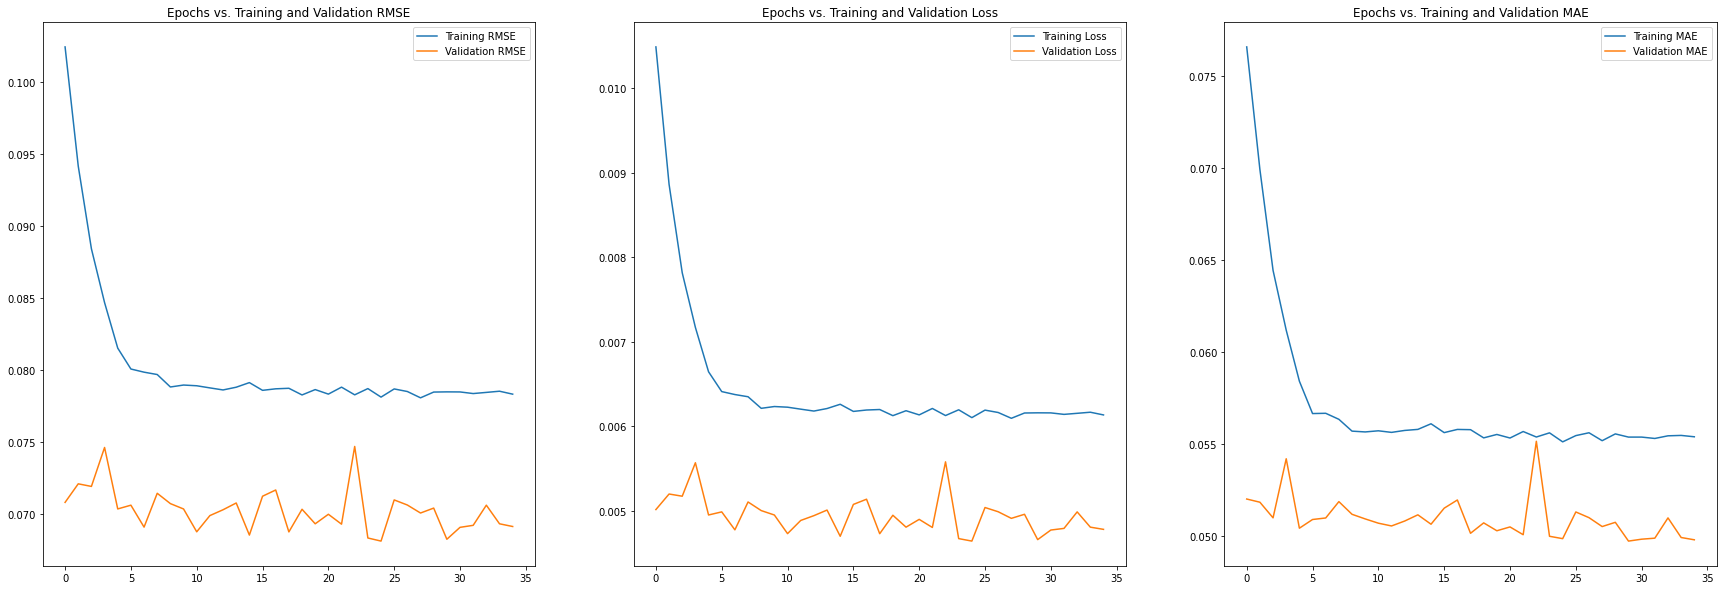

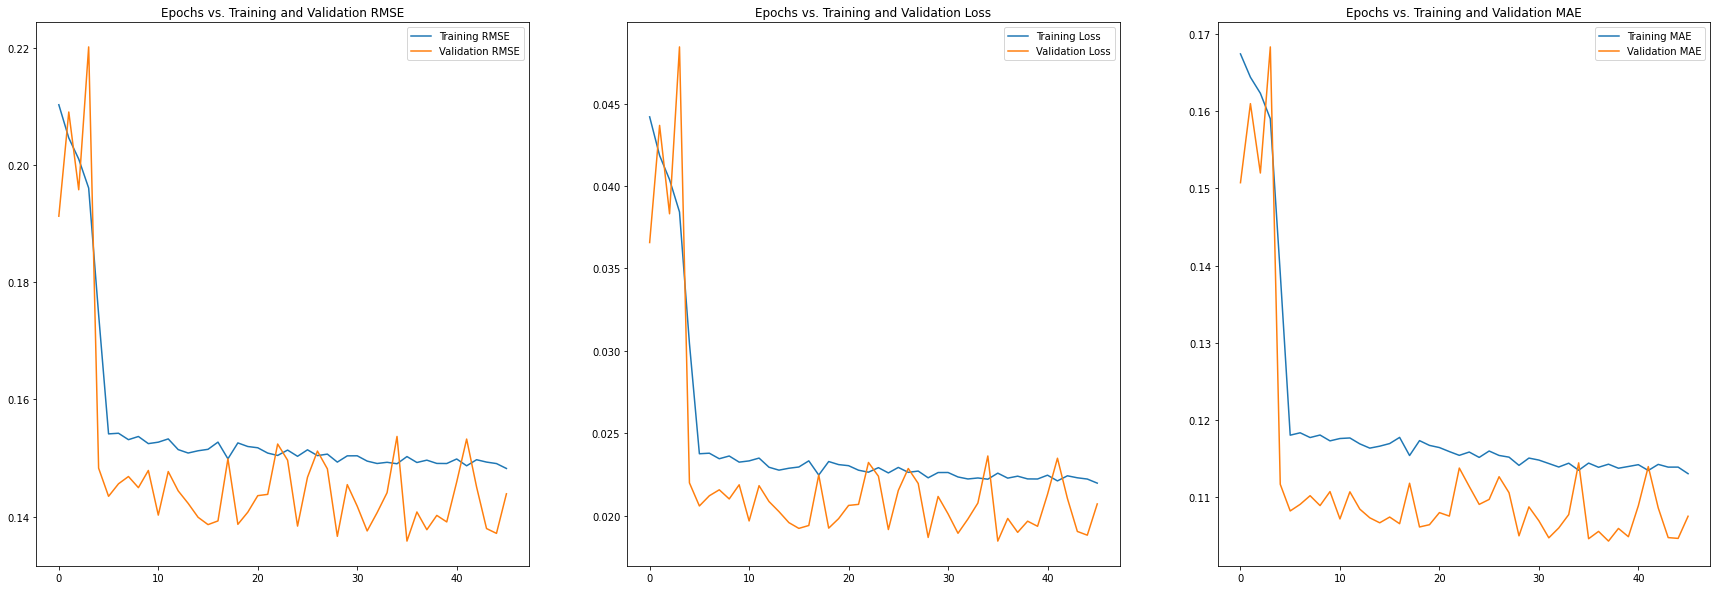

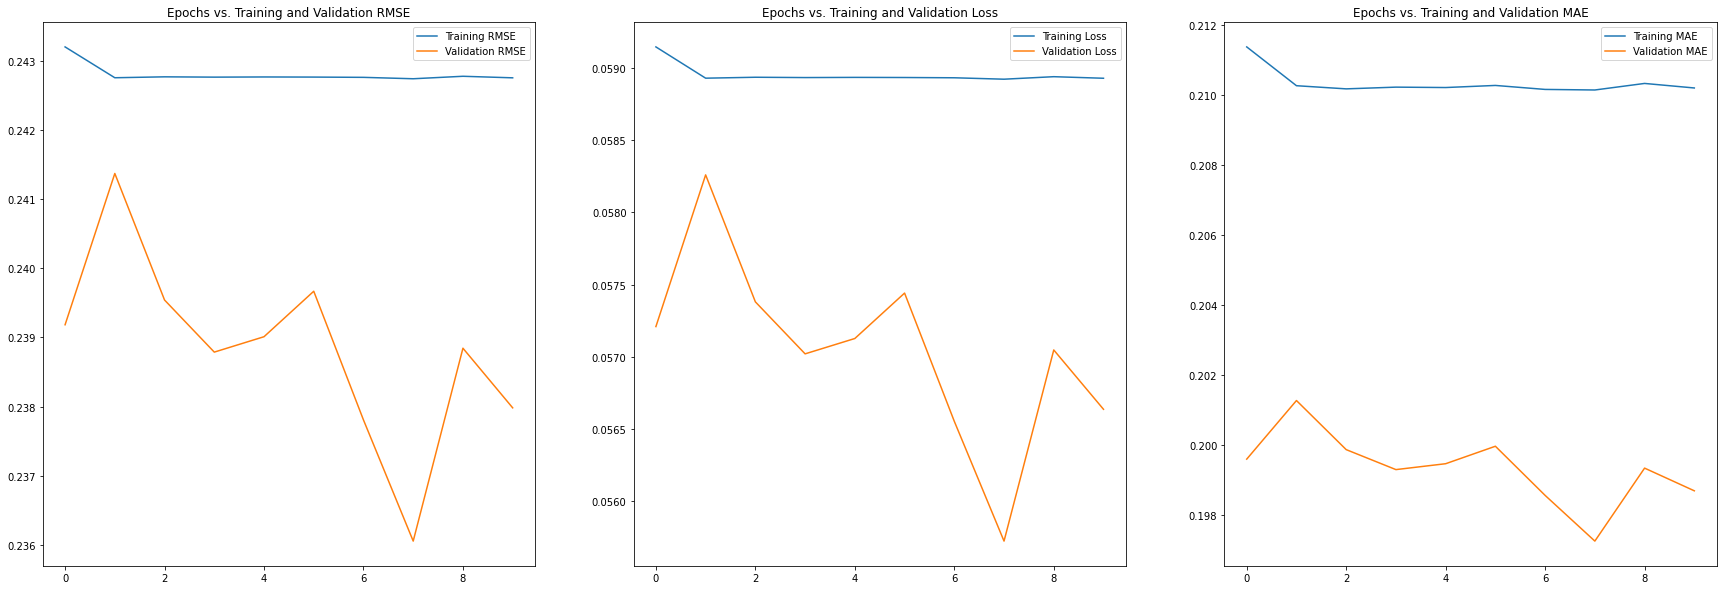

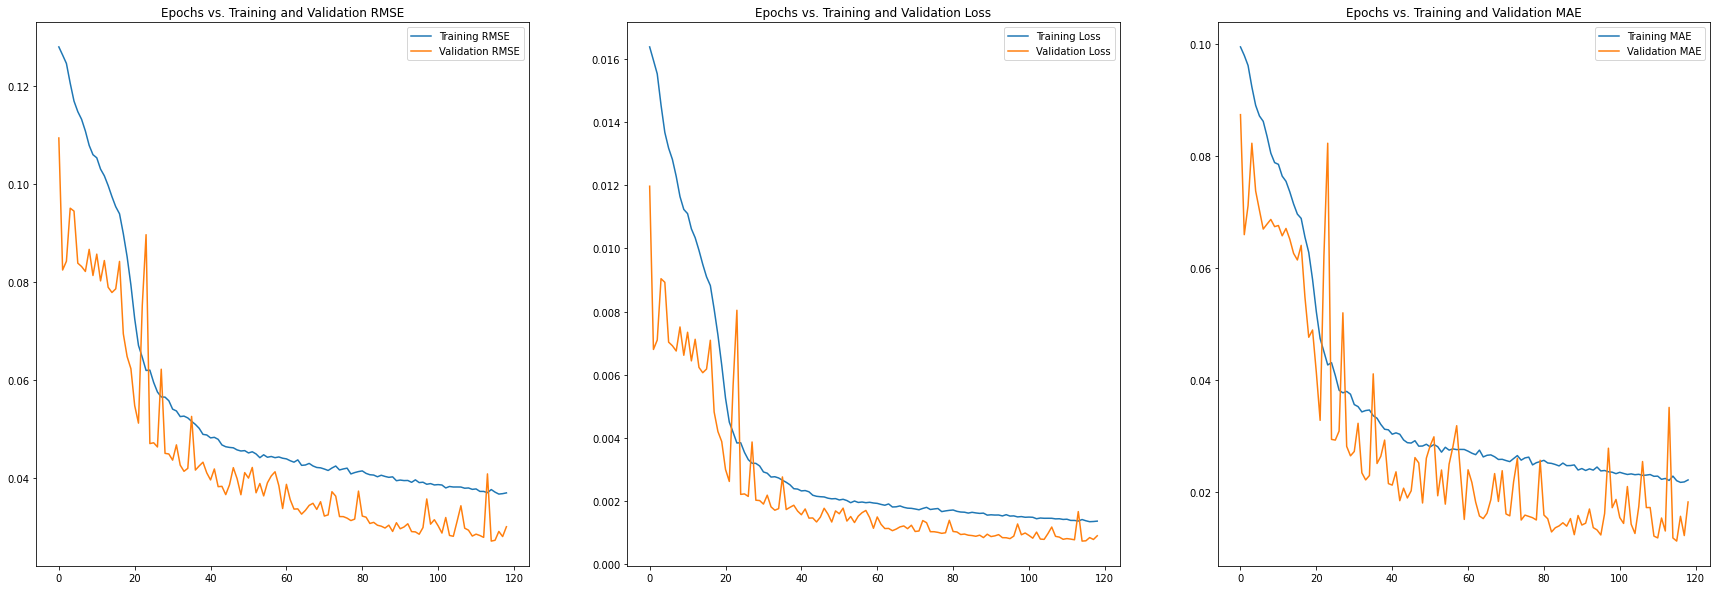

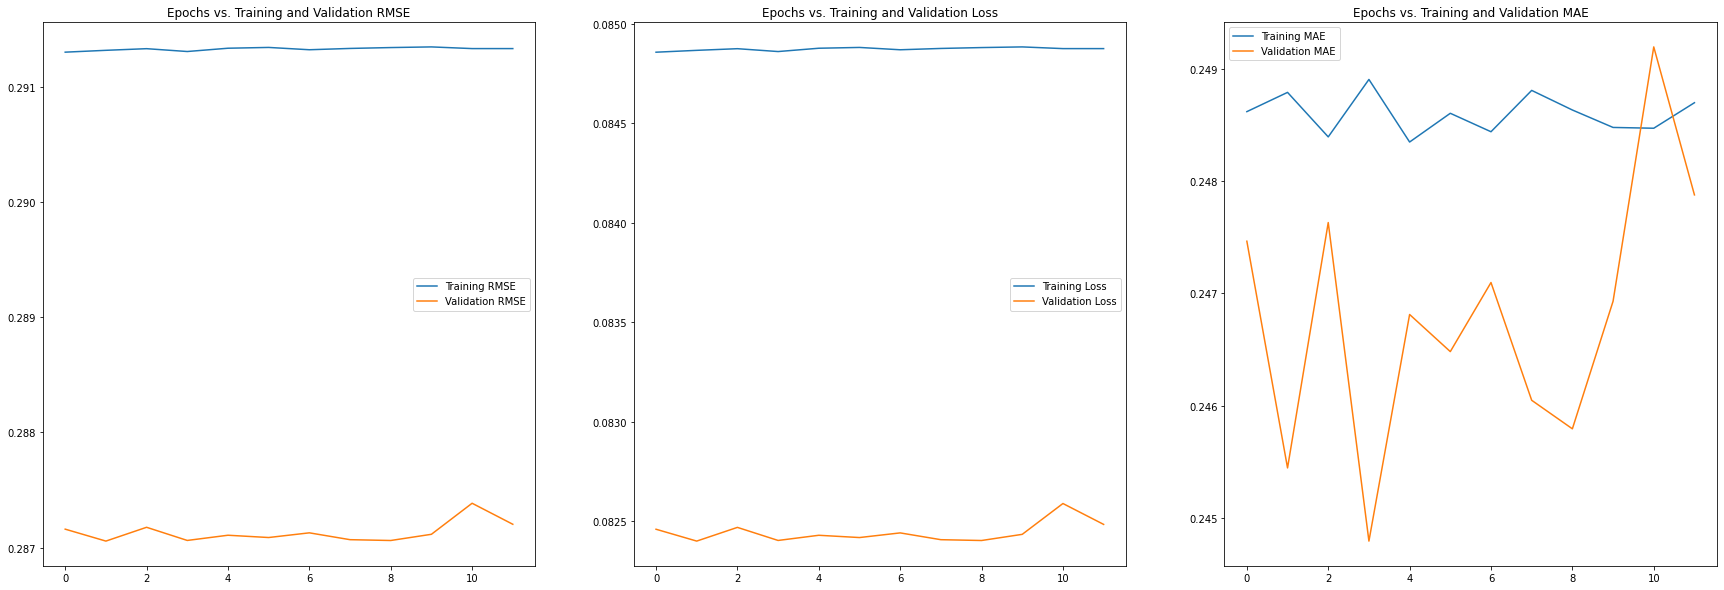

In [37]:
for type, history in stacked_lstm_models_history.items():

    plot_save_history(history, f'history/stacked_lstm_{type}_history')

### saving models

In [38]:
for type, model in stacked_lstm_models.items():

    model.save(f'models/stacked_lstm_{type}.h5')

### evaluation

In [40]:
stacked_lstm_models = {
    'solar'     : tf.keras.models.load_model('models/stacked_lstm_solar.h5'),
    'nuclear'   : tf.keras.models.load_model('models/stacked_lstm_nuclear.h5'),
    'biomass'   : tf.keras.models.load_model('models/stacked_lstm_biomass.h5'),
    'hwr'       : tf.keras.models.load_model('models/stacked_lstm_hwr.h5'),
    'fhc'       : tf.keras.models.load_model('models/stacked_lstm_fhc.h5'),
}

In [44]:
stacked_lstm_preds = {}
for type in generationTypes:

    model = stacked_lstm_models[type]
    
    X_test = datasets[type]['test']['x']
    y_test = datasets[type]['test']['y']

    evals[f'stacked_lstm_{type}'] = model.evaluate(X_test, y_test)
    stacked_lstm_preds[type] = model.predict(X_test)

45/45 [==============================] - 1s 13ms/step - loss: 0.0650 - root_mean_squared_error: 0.2550 - mean_absolute_error: 0.2277


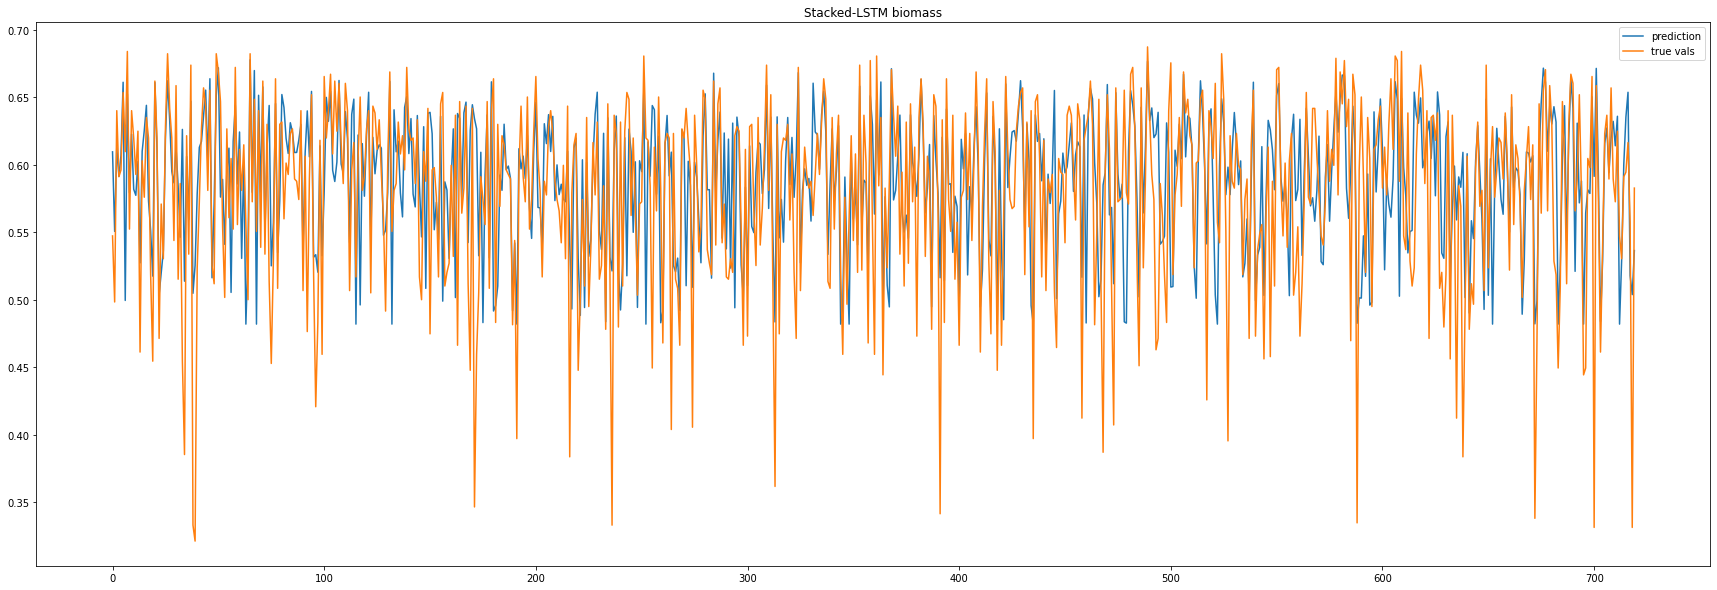

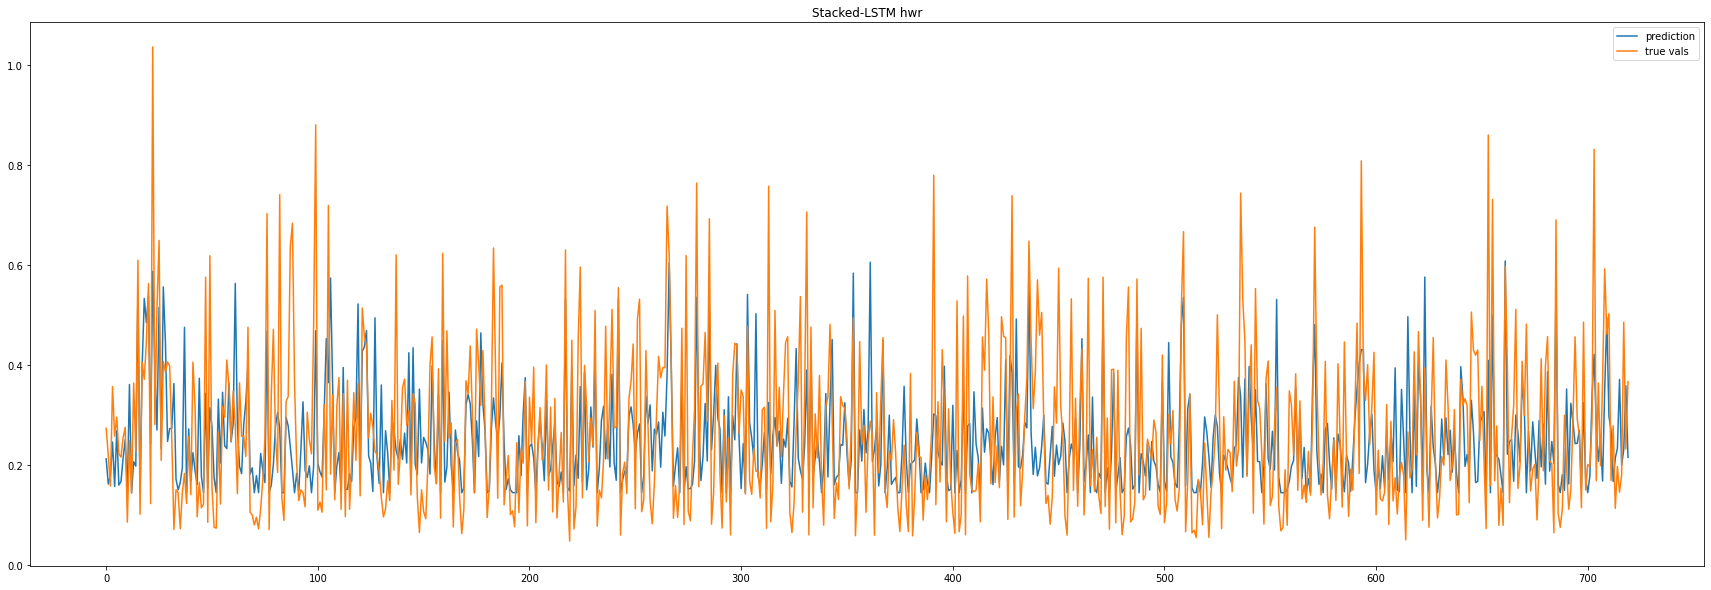

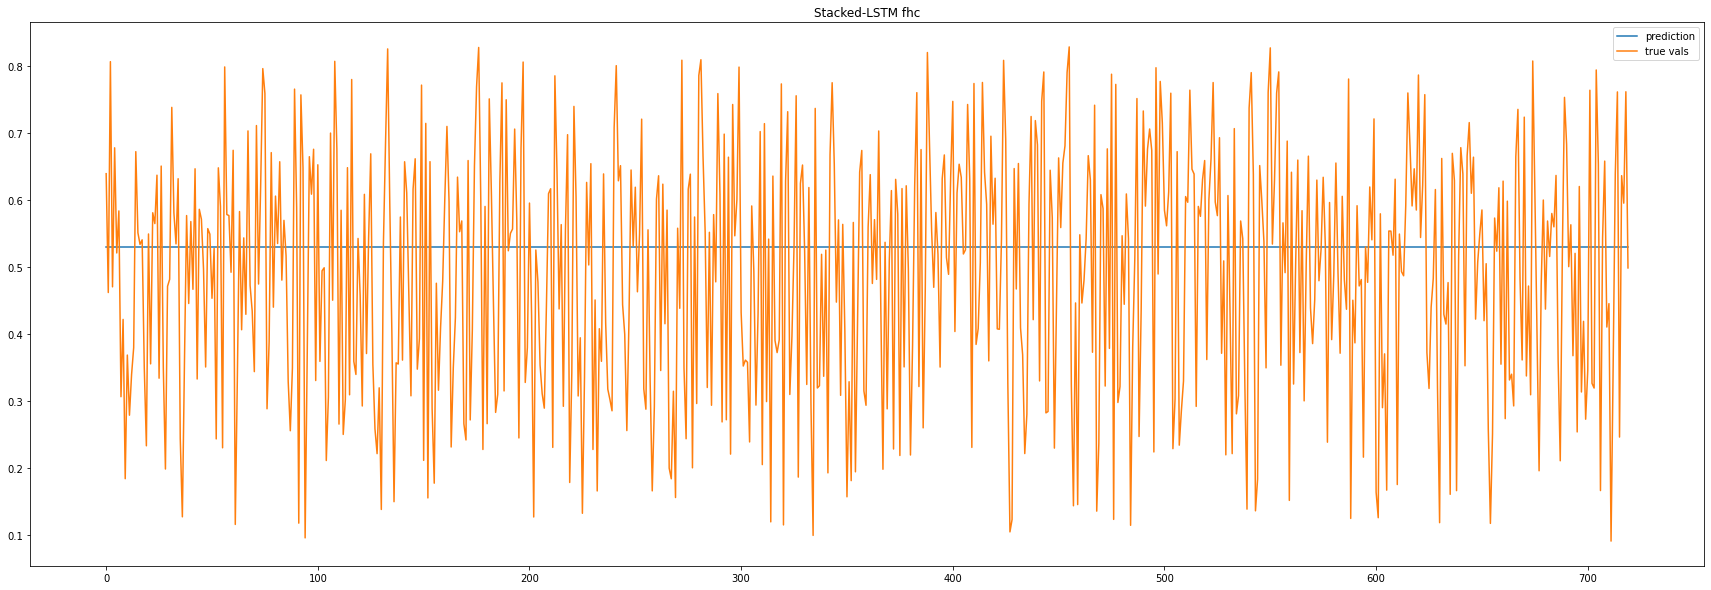

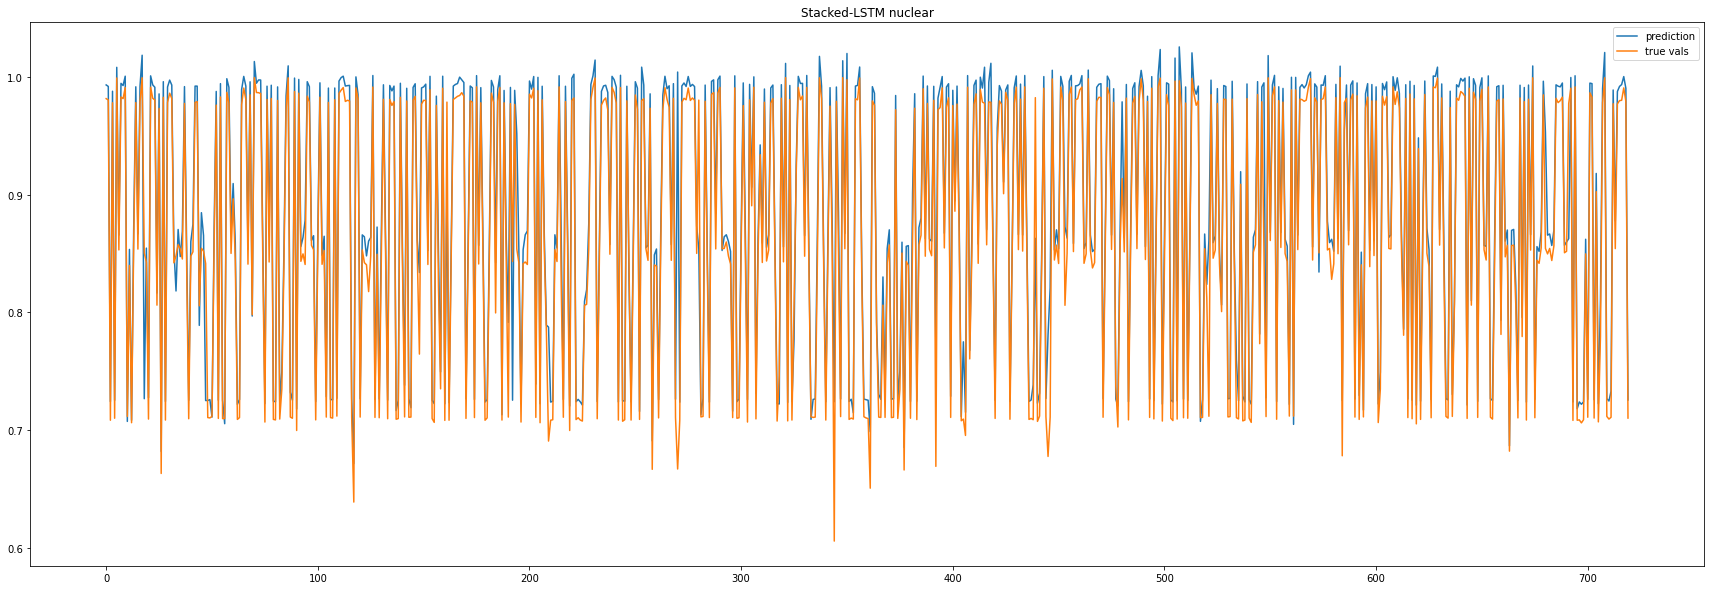

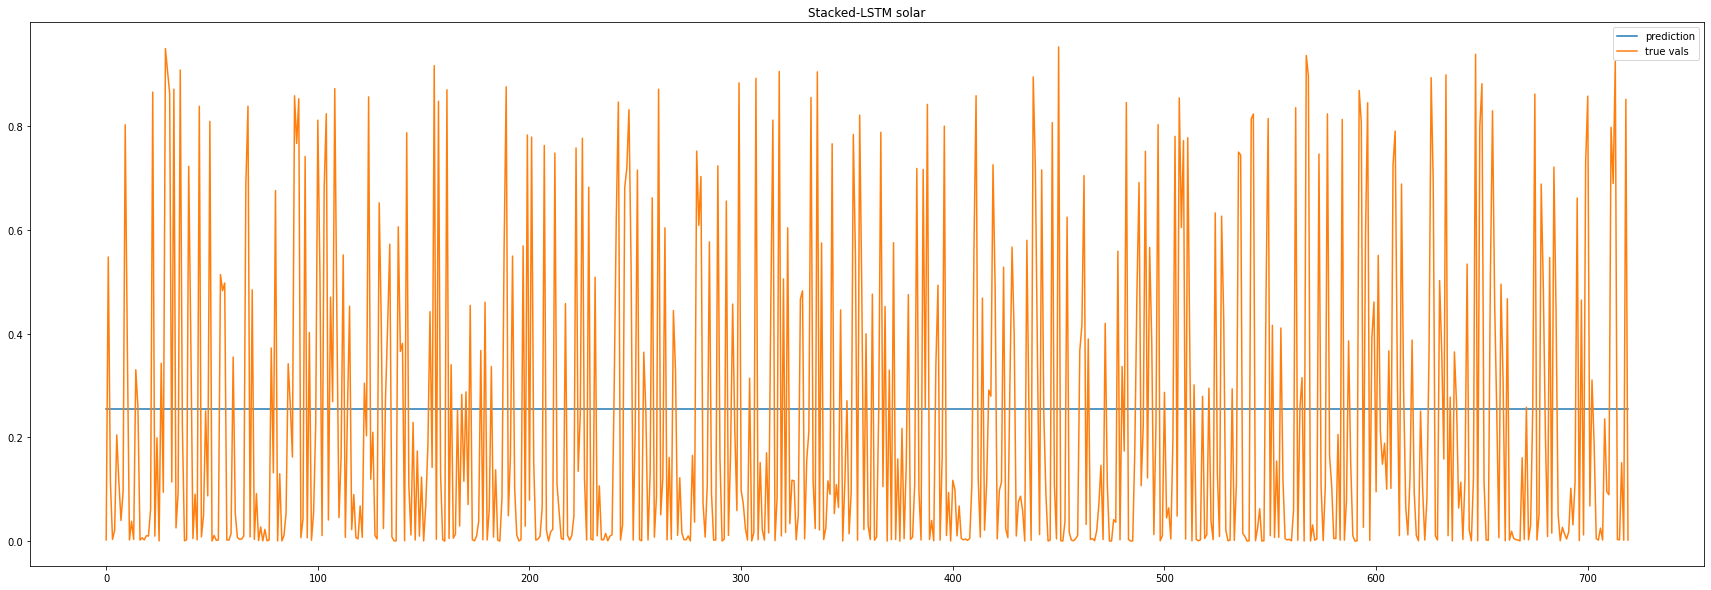

In [82]:
for type in generationTypes:

    p = stacked_lstm_preds[type][:24*30]
    y = datasets[type]['test']['y'].ravel()[:24*30]

    plt.figure(figsize= (30,10))
    plt.title(f'Stacked-LSTM {type}')
    plt.plot(p, label= 'prediction')
    plt.plot(y, label= 'true vals')
    plt.legend()
    plt.savefig(f'evaluation/stacked_lstm_{type}_evaluation.png')
    plt.show()


# Statistical models

In [33]:
pd.DataFrame(evals, index= errors).T

Empty DataFrame
Columns: [MSE, RMSE, MAE]
Index: []

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Creating Dataset and Making Train Test Split

In [18]:
arima_df    = df[:24*365]

size        = int(arima_df.shape[0] * (10/12))
train, test = arima_df[:size], arima_df[size:]


## Arima

### training and evaluating

In [21]:
arima_preds = {}

for X_train, X_test, type in zip(train.values.T, test.values.T, generationTypes):

    history     = list(X_train)
    predictions = []

    # walk-forward validation
    for row in X_test:
        model        = ARIMA(history, order= (5,1,0))
        model_fit    = model.fit()
        pred        ,= model_fit.forecast()
        
        predictions.append(pred)
        history.append(row)
        history.pop(0)
        

    # evaluate forecasts
    mse  = mean_squared_error(X_test, predictions)
    mae  = mean_absolute_error(X_test, predictions)
    rmse = mse ** .5

    evals[f'ARIMA_{type}']  = [ mse, rmse, mae ]
    arima_preds[type]       = predictions
    # print('here')

here
here
here
here
here


### plotting the results

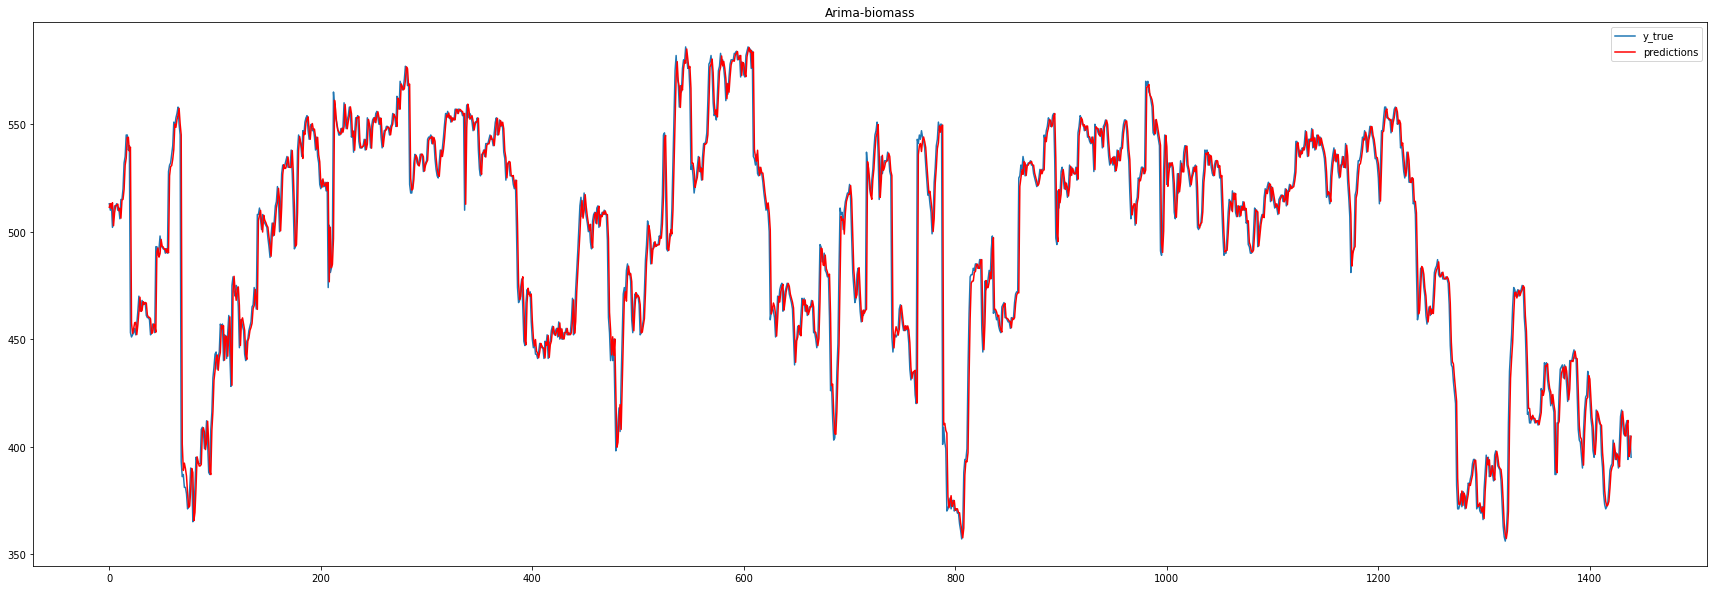

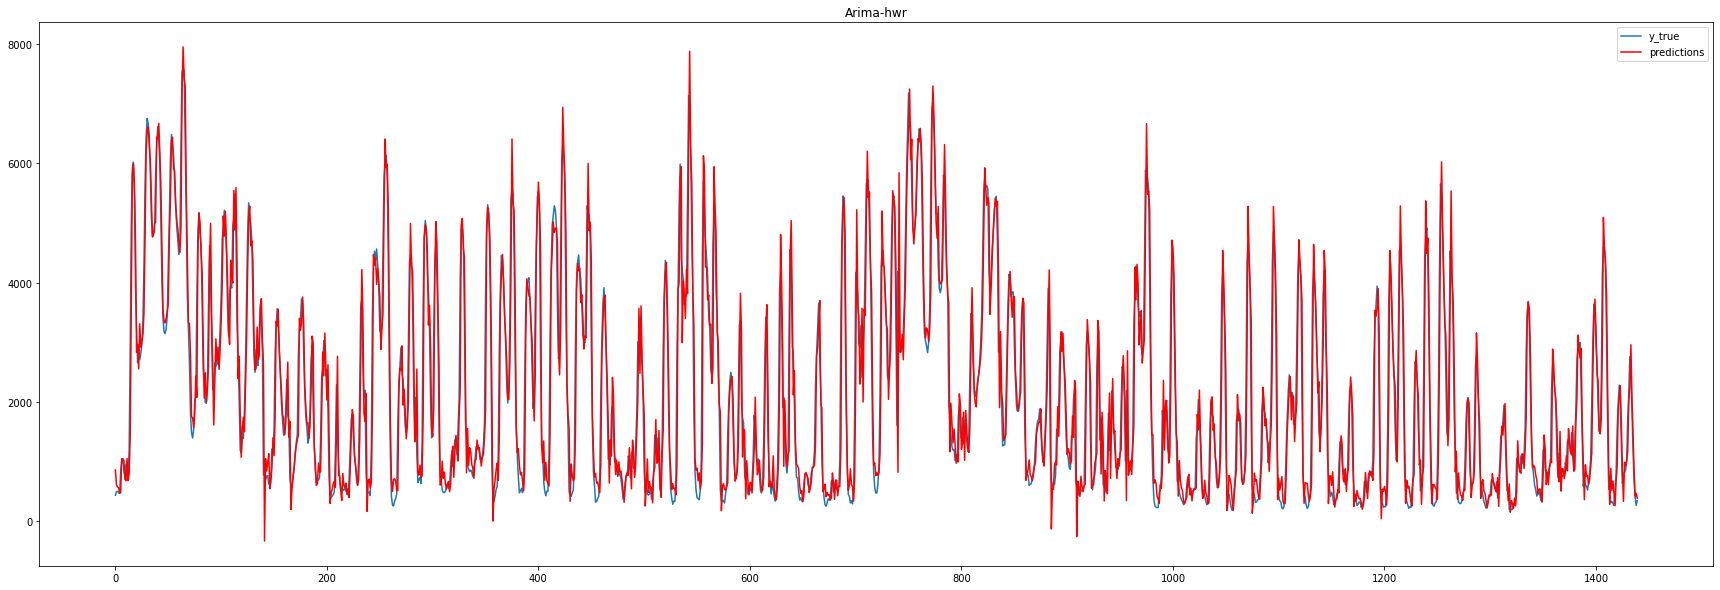

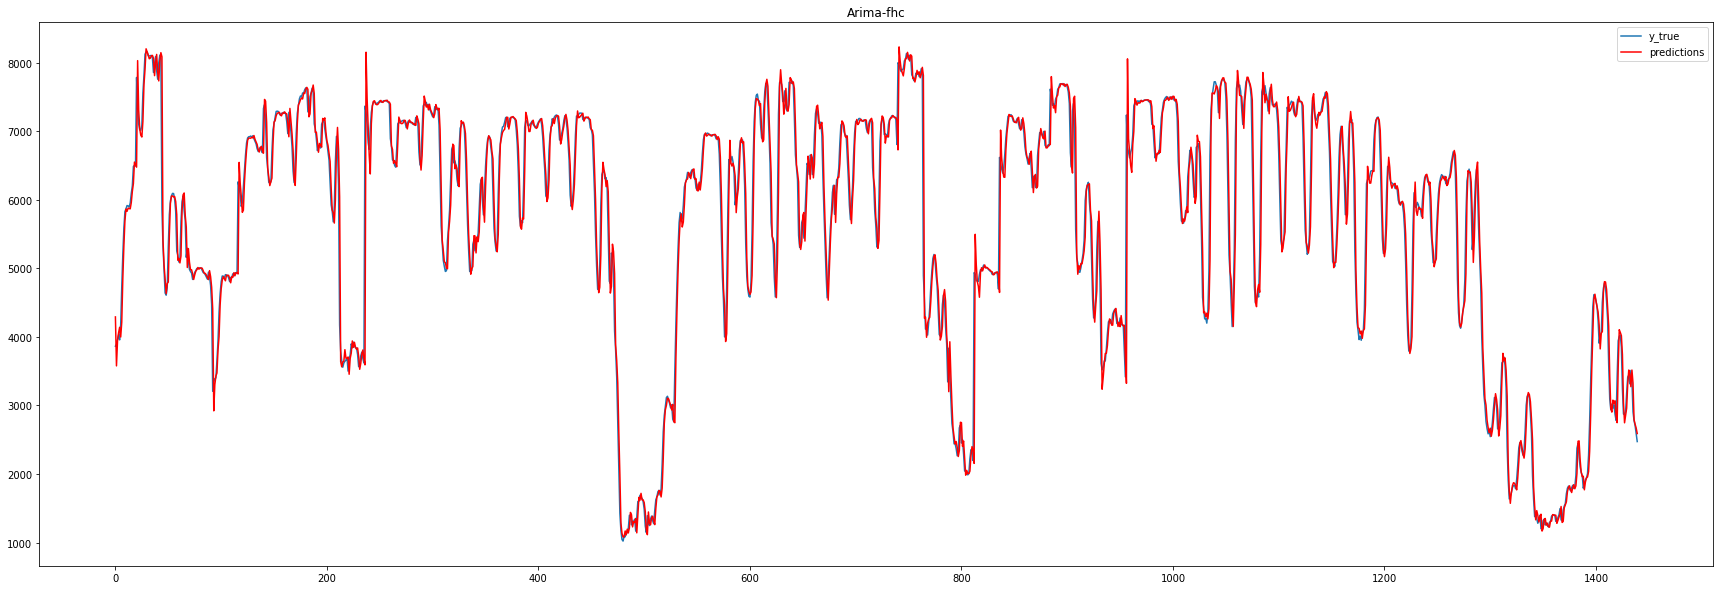

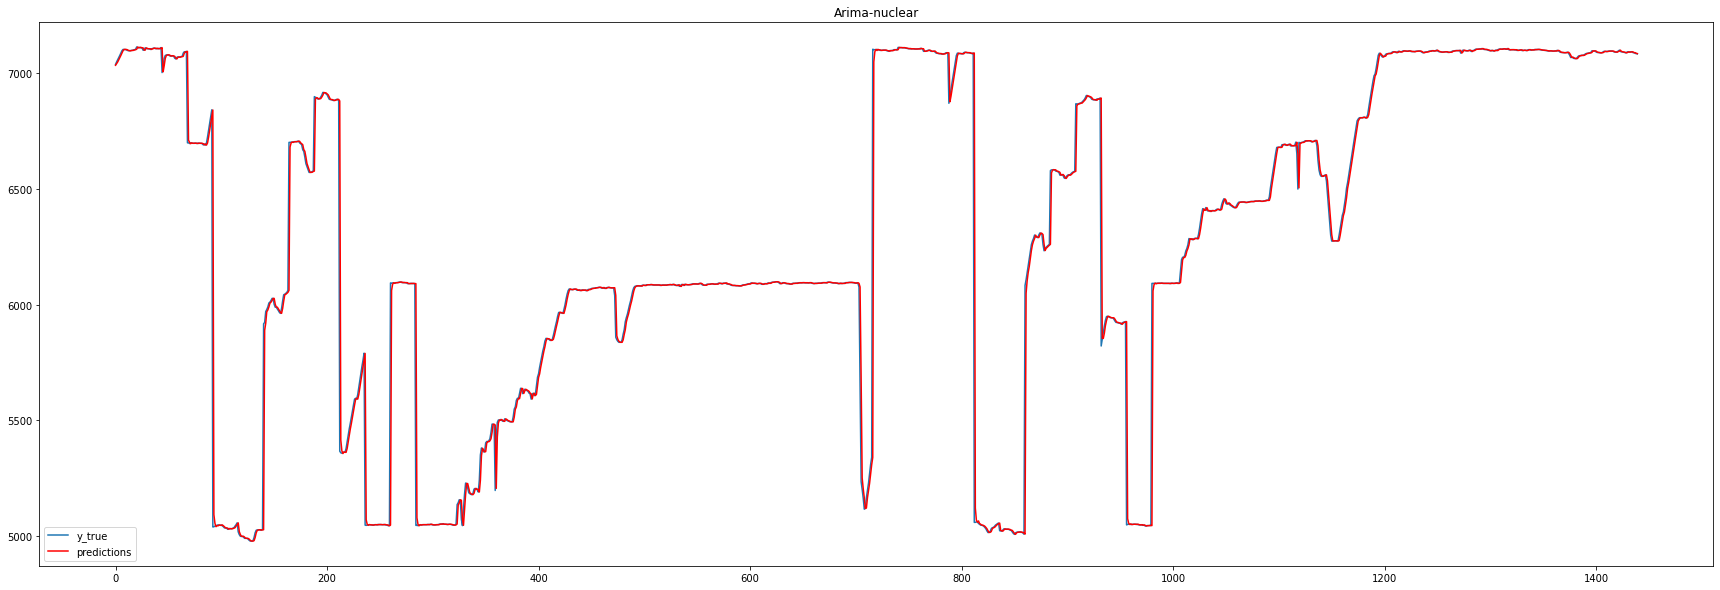

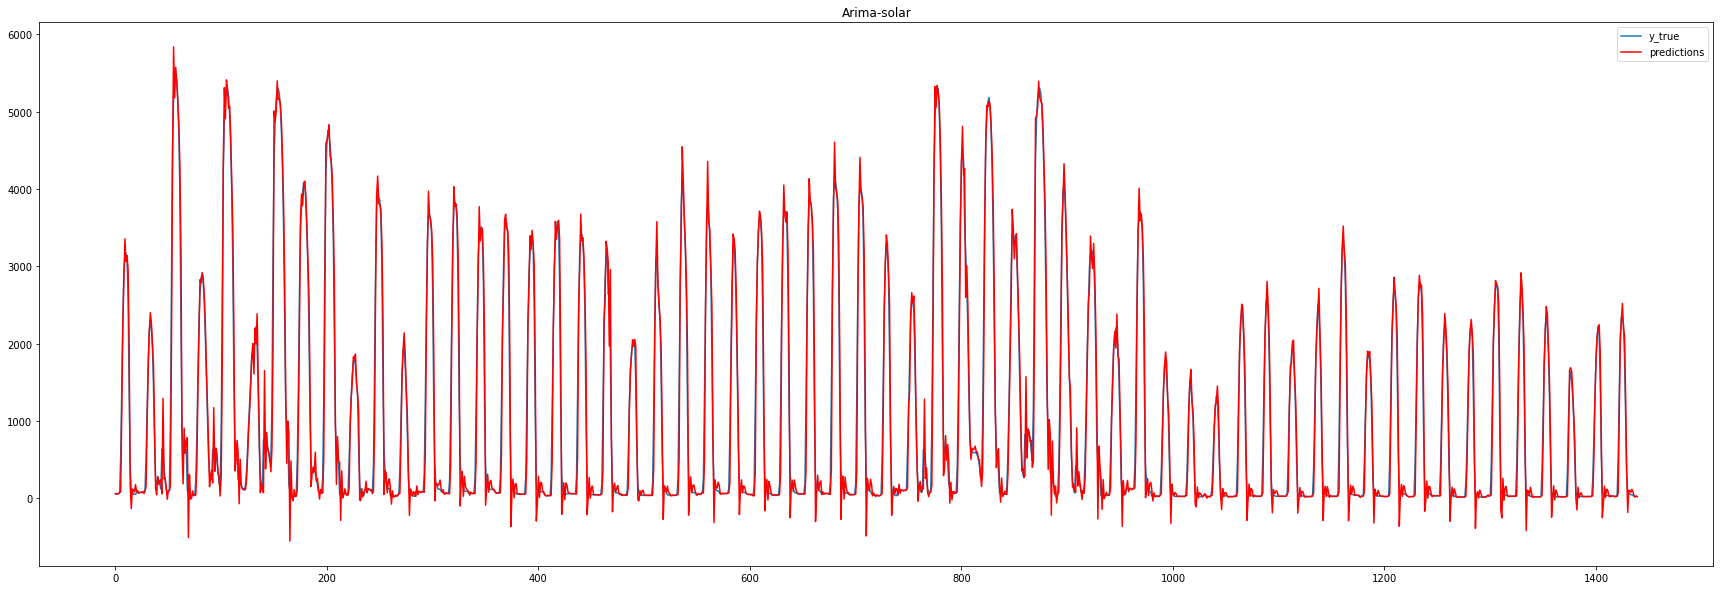

In [35]:
for X_test, type in zip(test.values.T, generationTypes):

    plt.figure(figsize=(30, 10))
    plt.title(f'Arima-{type}')
    plt.plot(X_test[:24*30*2], label='y_true')
    plt.plot(arima_preds[type][:24*30*2], color='red', label='predictions')
    plt.legend()
    plt.savefig(f'evaluation/arima_{type}_evaluation.png')
    plt.show()

# analysing and saving the evaluations

In [49]:
evaluations = pd.DataFrame(evals, index= errors).T
# evaluations.to_csv('model_evaluations.csv')

In [51]:
evaluations = pd.read_csv('model_evaluations.csv', index_col=0)
evaluations

MSE         RMSE          MAE
cnn_lstm_biomass      9.427014e-04     0.030703     0.018231
cnn_lstm_hwr          1.768821e-02     0.132997     0.104852
cnn_lstm_fhc          4.796336e-02     0.219005     0.185880
cnn_lstm_nuclear      3.286812e-04     0.018130     0.005645
cnn_lstm_solar        8.201557e-02     0.286384     0.244694
lstm_biomass          1.415877e-03     0.037628     0.024368
lstm_hwr              1.796482e-02     0.134033     0.109201
lstm_fhc              5.362865e-02     0.231579     0.195228
lstm_nuclear          1.244893e-02     0.111575     0.096310
lstm_solar            1.421944e-03     0.037709     0.029226
stacked_lstm_biomass  3.375910e-03     0.058103     0.039278
stacked_lstm_hwr      1.728150e-02     0.131459     0.099326
stacked_lstm_fhc      3.384789e-02     0.183978     0.152968
stacked_lstm_nuclear  6.713348e-04     0.025910     0.016577
stacked_lstm_solar    8.217511e-02     0.286662     0.245897
ARIMA_biomass         3.019281e+07  5494.798182  4472.078787
ARIMA_hwr             5.086833e+07  7132.203994  5507.973425
ARIMA_fhc             5.389466e+07  7341.298123  6157.616897
ARIMA_nuclear         2.660342e+07  5157.850542  3877.560486
ARIMA_solar           2.563690e+07  5063.289383  3705.724438